In [1]:
import os
from collections import OrderedDict

# What is different from V1:
I realized, that I can define losses directly to the embeddings. However I will probably have to pass different pairs of datasets for the different loss function - otherwise I will be trying to learn similarity on dissimilar things. I'll start with the "y" loss: The embedding for the head predicting "y" should be the same regardless of the experiment Id. I'm going to figure out a way to impose exactly that.

In [2]:
!cat bearing_fatigue_dataset/phm-ieee-2012-data-challenge-dataset/README.md

# PHM IEEE 2012 Data Challenge

This is a dataset that was used for the PHM IEEE 2012 Data Challenge. It used to be online at http://www.femto-st.fr/en/Research-departments/AS2M/Research-groups/PHM/IEEE-PHM-2012-Data-challenge.php, but isn't anymore.

The set contains a training set of 6 rolling bearings that were operated in three different conditions, and a testing set of 11 more. See the added PDF file for all the info of the challenge and the set.

## License

I don't know if there was any license to this, but always cite using below citation. There is a BibTeX entry in the PDF file.

## Citation

Nectoux, P., Gouriveau, R., Medjaher, K., Ramasso, E., Chebel-Morello, B., Zerhouni, N., … Varnier, C. (2012). PRONOSTIA : An experimental platform for bearings accelerated degradation tests. In IEEE International Conference on Prognostics and Health Management (pp. 1–8). Denver.



# TODO:
Read this: [Adversarial Discriminative Learning](http://openaccess.thecvf.com/content_cvpr_2017/papers/Tzeng_Adversarial_Discriminative_Domain_CVPR_2017_paper.pdf)
![image](img/AdversarialDiscriminativeDomainAdaptation.png)

# Load data:

In [3]:
import pandas as pd
import matplotlib.pyplot as pplot
import numpy as np
all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]
!ls bearing_fatigue_dataset/phm-ieee-2012-data-challenge-dataset/Learning_set/

load_from_disk = True;
if load_from_disk:
    def load_bearings_dataset(all_files = all_files):
        fnames = all_files
        exp_ids_tot = [];
        yrem_tot = [];
        sensor_values_tot = []

        for kk,fname in enumerate(fnames):
            p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
            p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6
            
            sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
            sens_val = np.dstack([v[1] for v in sensors.values])
            sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
            print(sensor_values.shape)

            yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
            yrem = np.abs(yrem - np.max(yrem))

            exp_id = np.hstack([kk for v in range(yrem.shape[0])])

            sensor_values_tot.append(sensor_values)
            exp_ids_tot.append(exp_id);
            yrem_tot.append(yrem)

            print(kk)

        yrem_tot = np.vstack(yrem_tot).flatten()
        eid = np.hstack(exp_ids_tot).flatten()
        X = np.vstack(sensor_values_tot)
        return yrem_tot, eid, X
    yrem_s_raw, eid, X = load_bearings_dataset()


Bearing1_1  Bearing1_2	Bearing2_1  Bearing2_2	Bearing3_1  Bearing3_2
(172, 2559, 2)
0
(1502, 2559, 2)
1
(1637, 2559, 2)
2
(515, 2559, 2)
3
(871, 2559, 2)
4
(1802, 2559, 2)
5
(2302, 2559, 2)
6
(1202, 2559, 2)
7
(1139, 2559, 2)
8
(2002, 2559, 2)
9
(572, 2559, 2)
10
(352, 2559, 2)
11
(797, 2559, 2)
12
(911, 2559, 2)
13
(612, 2559, 2)
14
(2803, 2559, 2)
15
(2302, 2559, 2)
16


## Adversarial learning on the FEMTO accelerated fatigue bearing dataset
The dataset is associated with a challenge for the PHM conference on 2012.
The motivation of this work is to investigate if and when adversarial learning on raw time-series performs well. The hypotheses of this work are the following:

* **Dilated DenseNets** are flexible enough to work with raw time-series (this is not an established fact in SHM applications)
* Adversarial learning can be used to normalize implicitly for **domain shifts** without manual intervention. 

The following need to be performed:
* Preprocessing (making the dataset appropriate for training with the adversarial densenet - domain labels etc)
* Train/test splitting for the raw accelerometer time-series
* write the optimization loop
* run prelim. experiments - hopefully something will fit. 
* write code for performing 1-vs-rest experiments to test generalization.

In [4]:
import tensorflow as tf
#tf.enable_eager_execution()

import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout

import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
#tf.keras.backend.set_session(sess)
#from tensorflow.math import confusion_matrix

In [5]:
tf.__version__

'2.1.0'

In [6]:
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

def calc_receptive_field(Nd, Nf, conv_type = "causal"):
    "returns the number of input taps each layer in a dilated caysal conv stack sees."
    if conv_type == "causal":
        corr = [0]+[1]*(len(Nd)-1)#correction for double counted neurons.
    
    return np.cumsum([(nf_) * (nd_) - (nd_-1) - c for nf_, nd_ ,c in zip(Nf, Nd, corr)])  #- (len(Nd)) + 1


from src.util import plot_confusion_matrix
from src.experiments_utils import *

ndn = 4
nkernel = 4;
ndn2 = 6
ndomain = 17;

experiment_parametrization = {
    'dilation_rates_dn1': [1,4,8,16,32,64,128,256,512,8,16,32,64,128,512][0:ndn],#,4,8,16,32],
    'kernel_sizes_dn1' :  [nkernel] * ndn,#,5,5],
    'nfilters_dn1' :  [50]*ndn,
    'dilation_rates_dn2' : [2]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)
#

model_json['classifier']['network_layers'][0]['params']['units'] = 640
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"][0]['params']["dropout_after_composite"] = 0.1
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
model_json['inputs'][0]['shape'] = (2559,2)
model_json['domain_classifier']['network_layers'][-1]['params']['units'] = ndomain
# Make the model act as a regressor:
model_json['classifier']['network_layers'][-1]['params']['units'] = 1
Nf = model_json['densenet_1d']['network_layers'][0]['params']['kernel_sizes']
Nd = model_json['densenet_1d']['network_layers'][0]['params']['dilation_rates']
#model_json['densenet_1d']['network_layers']
#single_DN_stack_rf = calc_receptive_field(Nd,Nf)
#single_DN_stack_rf * len(Nf)
calc_receptive_field(Nd,Nf) * len(Nf)


array([ 16,  64, 160, 352])

In [7]:
xin = tf.keras.Input(shape = (None, 2) , name = "timeseries_input"); 
nfilts = 64;
nfilts2 = 128
ksize = 2;

yout = Conv1D(kernel_size = 1 , filters = 100, strides = 1, use_bias = False)(xin)
yout = Conv1D(kernel_size=ksize,filters = nfilts, strides=2, use_bias= False)(yout)
yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,use_bias= False)(yout)
yout = Dropout(rate = 0.2)(yout)
yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,activation  = "relu",use_bias= True)(yout)
yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

yout = Conv1D(kernel_size=ksize, strides=2, filters = nfilts2,use_bias= False)(yout)
yout = Dropout(rate = 0.2)(yout)
yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= False)(yout)
yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= False)(yout)
yout = keras.layers.AveragePooling1D(pool_size=2)(yout)



# yout = Conv1D(kernel_size=5,filters = nfilts2, strides=2,use_bias= False)(yout)
# yout = Dropout(rate = 0.1)(yout)
# yout = Conv1D(kernel_size=5,strides=2, filters = nfilts2,use_bias= False)(yout)
# yout = Conv1D(kernel_size=5,strides=2, filters = nfilts2,activation  = "relu",use_bias= False)(yout)


yout = keras.layers.GlobalAveragePooling1D()(yout)

mconv = keras.Model(inputs = xin, outputs = yout)
mconv.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
timeseries_input (InputLayer [(None, None, 2)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         200       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          12800     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          8192      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          8256      
_________________________________________________________________
average_pooling1d (AveragePo (None, None, 64)          0     

In [8]:
# I need to transform the model to 
## Make the creation of discriminators between domains automatic:



#base_model = make_model(model_json)
base_model = mconv;
get_global_pool_layer = lambda mm : mm.get_layer([l.name for l in mm.layers if 'global_average' in l.name][0])
from src.dilated_densenet_adversarial import GradReverse

# The definition of the domains:
d_y = {'name' : 'y' , 'output_head_size' : 1, "loss" : lambda y,yhat : tf.reduce_mean(tf.abs(y-yhat))}
d_d = {'name' : 'd' , 'output_head_size' : 17, "loss" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat)}
d_l = {'name' : 'l' , 'output_head_size' : 3, "loss" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat)}

#domains = [d_a,d_b,d_c]

# Define domain relations:
#a_i sub c
#c sub b

DDA_input_layer = get_global_pool_layer(base_model)

def make_sep_model_heads_fcn(features_input_layer, head_params):
    """
    Returns 4 network heads, their embedding layers, 
    and their respective losses for a discriminative domain adversarial network.
    """
    
    d1_name, d1_out, d1_loss = [head_params[0][hval] for hval in ['name' , 'output_head_size' , 'loss']]
    d2_name, d2_out, d2_loss = [head_params[1][hval] for hval in ['name' , 'output_head_size' , 'loss']]
    
    Ename_d1d2 = "P_%s_C_%s"%(d1_name,d2_name);
    Ename_d2d1 = "P_%s_C_%s"%(d2_name,d1_name);
    
    # The embeddings that learn @ each domain separately:
    Emb_P_d1_C_d2 = keras.Sequential([
        keras.layers.Dense(100,activation = "relu") ,
        keras.layers.Dense(100, use_bias = False),
        Dropout(rate = 0.2),
    ], name = Ename_d1d2)(features_input_layer.output)
    
    Emb_P_d2_C_d1 = keras.Sequential([
        keras.layers.Dense(100,activation = "relu") ,
        keras.layers.Dense(100, use_bias = False),
        Dropout(rate = 0.2),
    ],name =Ename_d2d1)(features_input_layer.output)
    
    def make_class_head(emb_in, out_size , name):
        """
        emb_in   : the input tensor to the stack
        out_size : the output of the stack (for classifier it is the number of classes. For regressor it is "1".)
        name     : the name of the output. The name contains the input embedding, and whether it is a critic or a predictor.
        """
        
        domain_critic_or_predictor    = keras.Sequential(name = name)

        # if this is a "critic" head a grad reverse layer is added:
        if name[-6:] == "critic":
            domain_critic_or_predictor.add(GradReverse());
        
        domain_critic_or_predictor.add(Dense(100, activation = 'relu'))
        domain_critic_or_predictor.add(Dense(100, use_bias = False))
        domain_critic_or_predictor.add(Dropout(rate = 0.2))
        domain_critic_or_predictor.add(Dense(out_size));

        return domain_critic_or_predictor(emb_in)
    
    # Construct the critic and the predictor for each domain:
    Pd1Cd2_d2_critic , Pd1Cd2_d1_predictor = [make_class_head(Emb_P_d1_C_d2 , out_size ,"%s_%s"%(Ename_d1d2, head_)) 
                                              for out_size, head_ in zip([d2_out,d1_out], ["critic", "predictor"])];
    
    Pd2Cd1_d1_critic , Pd1Cd2_d2_predictor = [make_class_head( Emb_P_d2_C_d1 ,out_size, "%s_%s"%(Ename_d2d1, head_)) 
                                              for out_size,head_ in zip([d1_out,d2_out], ["critic", "predictor"])];
    
    
    losses = {"%s_%s"%(Ename_d1d2, "critic")    : d2_loss , "%s_%s"%(Ename_d1d2, "predictor") : d1_loss,
              "%s_%s"%(Ename_d2d1, "predictor") : d1_loss , "%s_%s"%(Ename_d2d1, "critic") : d2_loss}
    losses = OrderedDict(losses)
    outputs = [Pd1Cd2_d2_critic , Pd1Cd2_d1_predictor , Pd2Cd1_d1_critic , Pd1Cd2_d2_predictor]
    
    outputs_expected_label  = [d2_name, d1_name, d2_name, d1_name];
    
    return outputs, losses, outputs_expected_label

outputs_ab = make_sep_model_heads_fcn(DDA_input_layer, [d_y, d_d])
outputs_ac = make_sep_model_heads_fcn(DDA_input_layer, [d_y, d_l])
outputs_bc = make_sep_model_heads_fcn(DDA_input_layer, [d_d, d_l])

all_output_domains = [*outputs_ab[2],          *outputs_ac[2]         ,*outputs_bc[2]]
all_outputs        = [*outputs_ab[0],          *outputs_ac[0]         ,*outputs_bc[0]]
all_loss_names     = [*outputs_ab[1].keys(),   *outputs_ac[1].keys(),  *outputs_bc[1].keys()]
all_loss_functions = [*outputs_ab[1].values(), *outputs_ac[1].values(),*outputs_bc[1].values()]

losses = OrderedDict({k:v for k,v in zip(all_loss_names, all_loss_functions)})
#rules = ("d_a" , "d_b" , "sep"),    
    
    

In [9]:
disc_adv = keras.Model(inputs = base_model.input, outputs = all_outputs)
#inspect_ddout = Model(inputs = base_model.get_layer("timeseries_input").input,outputs = base_model.get_layer("DN_DN1_Out").output)


In [10]:
disc_adv.output

[<tf.Tensor 'P_y_C_d_critic/Identity:0' shape=(None, 17) dtype=float32>,
 <tf.Tensor 'P_y_C_d_predictor/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'P_d_C_y_critic/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'P_d_C_y_predictor/Identity:0' shape=(None, 17) dtype=float32>,
 <tf.Tensor 'P_y_C_l_critic/Identity:0' shape=(None, 3) dtype=float32>,
 <tf.Tensor 'P_y_C_l_predictor/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'P_l_C_y_critic/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'P_l_C_y_predictor/Identity:0' shape=(None, 3) dtype=float32>,
 <tf.Tensor 'P_d_C_l_critic/Identity:0' shape=(None, 3) dtype=float32>,
 <tf.Tensor 'P_d_C_l_predictor/Identity:0' shape=(None, 17) dtype=float32>,
 <tf.Tensor 'P_l_C_d_critic/Identity:0' shape=(None, 17) dtype=float32>,
 <tf.Tensor 'P_l_C_d_predictor/Identity:0' shape=(None, 3) dtype=float32>]

In [11]:
# I'm going to feed data that should be similar from different experiments and minimize their L2 losses:
input_exper = Input(shape = (17,))
prediction = tf.keras.Sequential([Dense(100,activation = "relu"),
                                 Dense(100, use_bias = False),
                                 Dropout(rate = 0.2),
                                 Dense(1)], name = "prediction")(disc_adv.get_layer("P_y_C_d").output)

emb_PyModel_a=keras.Model(inputs = [disc_adv.input ,input_exper], outputs = [tf.keras.layers.concatenate([disc_adv.get_layer("P_y_C_d").output,input_exper], name = "embedding"), prediction])

#emb_PyModel_b=keras.Model(inputs = disc_adv.input , outputs = disc_adv.get_layer("P_y_C_d").output)
#emb_PyModel_diff = keras.Model(inputs = [emb_PyModel_a.input, emb_PyModel_b.input], outputs = [emb_PyModel_a.output, emb_PyModel_b.output])


In [12]:
#e = [[1,0,0],[0,1,0]]
#y = [0.1,0.1]
def loss_fcn(yreal,yhat):
    W= tf.matmul(yhat[:,0:-17], yhat[:,-17:], transpose_a=True, transpose_b=False)
    Vmeans = tf.transpose(tf.matmul(W , yhat[:,-17:], transpose_a = False, transpose_b = True))
    loss_mean = tf.reduce_sum(tf.square(yhat[:,0:-17] - Vmeans), axis=0)
    loss_norm = tf.reduce_sum(tf.abs(tf.reduce_mean(tf.square(yhat[:,0:-17]), axis = 1)-1), axis = 0) # approximately the squared norm of each row should be close to 1.
    return (loss_mean + loss_norm) * 0.0001

def loss_fcn_pred(yreal, yhat):
    return tf.reduce_sum(tf.square(yreal - yhat))

#class plt_diag(tf.keras.Call)
# v1 = emb_PyModel_a([x_train[0:10],d_train[0:10]])
# loss_fcn_dict = {"embedding" : loss_fcn, "prediction" : loss_fcn_pred}
# emb_PyModel_a.compile(loss = loss_fcn_dict , optimizer= 'Adam')
# h = emb_PyModel_a.fit([x_train, d_train],[x_train, y_train], epochs=20)

In [13]:
from sklearn.decomposition import PCA
v1 = emb_PyModel_a.predict([x_train[0:2000],d_train[0:2000]], batch_size=100)
ypca = PCA(n_components = 2).fit_transform(v1[0][:,0:100])
pplot.scatter(ypca[:,0], ypca[:,1], c= np.argmax(d_train[0:2000],1))
pplot.show()
pplot.scatter(ypca[:,0], ypca[:,1], c= y_train[0:2000])

NameError: name 'x_train' is not defined

In [14]:
v1 = emb_PyModel_a([x_train[0:10],d_train[0:10]])

v = v1.numpy()
W= v[:,0:-17].T @ v[:,-17:]
#W = W -np.mean(W,1)[np.newaxis].T
#pplot.pcolor(W.T @ W)
pplot.pcolor((W @ v[:,-17:].T))
pplot.show()
pplot.plot(np.argmax(v[:,-17:],1))

NameError: name 'x_train' is not defined

In [15]:
W

NameError: name 'W' is not defined

In [16]:
v[:,17:].shape

NameError: name 'v' is not defined

In [17]:
v1 = np.random.randn(100,5)


In [18]:
yrem = [];
for ee in np.unique(eid):
    yelapsed_ = np.cumsum(yrem_s_raw[eid == ee])
    yrem_ = np.max(yelapsed_) - yelapsed_;
    yrem.append(yrem_)
yrem = np.hstack(yrem)

## Taking data from the end
In order to 

* ballance the classes
* have time-series with more features related to failure

the time-series is truncated closer to the failure of the specimens.

## Train-test splitting:

In [19]:
# split_files by operating conditions:
operating_conditions = ['1','2','3'];
files_per_condition = {oc : [(f,idx, np.max(yrem_s_raw[eid == idx])) for idx,f in enumerate(all_files) if f[5] == oc] for oc in operating_conditions}
files_per_condition

{'1': [('AccB_1_7.pickle', 1, 15010.0),
  ('AccB_1_2.pickle', 4, 8700.0),
  ('AccB_1_3.pickle', 5, 18010.002),
  ('AccB_1_5.pickle', 6, 23010.0),
  ('AccB_1_4.pickle', 8, 11380.002),
  ('AccB_1_1.pickle', 15, 28072.203),
  ('AccB_1_6.pickle', 16, 23010.0)],
 '2': [('AccB_2_7.pickle', 0, 1710.0),
  ('AccB_2_3.pickle', 7, 12010.0),
  ('AccB_2_5.pickle', 9, 20010.0),
  ('AccB_2_6.pickle', 10, 5710.0),
  ('AccB_2_2.pickle', 12, 7960.0),
  ('AccB_2_1.pickle', 13, 9100.0),
  ('AccB_2_4.pickle', 14, 6110.0)],
 '3': [('AccB_3_2.pickle', 2, 16360.0),
  ('AccB_3_1.pickle', 3, 5140.0),
  ('AccB_3_3.pickle', 11, 3510.0)]}

## Manual selection of some tests for training, considering the cycles to failure.
 In order to be able to generalize, it is better if the strong test set comprises of tests that
 fail in the range of the training set. The sellection goes as follows:
 
 |condition |set|experiment indices|total time to failure|exp_strings|
 |-- | -- | -- | -- |--|
 |1| training | (4, 6, 8, 15)| (8700, 23010, 11380, 28072) |... |
 |2|training|(9, 10, 0,7)|(20010,5710,1710,12010)|...|
 |3|training|(2,11)|(16360,3510) | ...|
 |1|validation| (1, 5, 16) | (15010, 18010, 23010) | ...|
 |2|validation|(12,13,14)|(7960,9100,6110)|...|
 |3|validation|(3) | (5140)|...|



## A schematic of the goal of domain separation learning

In the following the hierarchical domain separation problem is depicted. 

![image](img/AdversarialDiscriminativeDomainAdaptation_ideal_learned_domain.png)

By learning to transfer from one domain to the other the "lines" depicted in the chart are implicitly learned.
A representation is defined as a transformation from raw data to a set of numbers possessing certain properties allowing for certain down-stream tasks such as prediction or generation.
In the following $\mathcal{D}_A$ denotes the set of representations from domain $A$ 
In essence the "lines" can be thought of implicit parametric embeddings. Note that if $\mathcal{F[\cdot]}$ denotes the features in a domain,

\begin{equation}
\mathcal{F}[\mathcal{D}_A \cap \mathcal{D}_B ]
\end{equation}

is what is implicitly learned from *Domain adversarial training* between $\mathcal{D}_A$ and $\mathcal{D}_B$. The sub-domains of the representation used in the task may contain non-overlapping instances. It may be difficult or impossible to learn how to generate from each domain or transform from one instance-locked domain to another. In the bearing dataset, the domains of each experiment are expected to contain some features useful from prediction. The $\mathcal{D}_A$ and $\mathcal{D}_B$ sample sets correspond to the different loading conditions, and the $\mathcal{D}_{E^i}$ domains correspond to each different experiment. The different experiments contain a **private** representation as well as a **shared** "part" of the repesentation.



In [20]:
# def stats(x):
#     pplot.plot(x.values[:,0])
#     pplot.show()
#     return x['yrem'].std()

# dd = pd.DataFrame({"yrem":yrem_norm, "cond":np.argmax(loading_oh,1),"eid":np.argmax(eid_oh,1)})
# pplot.plot(dd.cond);
# pplot.plot(dd.eid)
# dd.groupby("cond").count()
# #dd.groupby("eid").apply(stats)
# #dd

In [21]:
eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
for k in np.unique(eid):
    eid_oh[eid == k,k] = 1.;

yrem_norm = yrem / np.std(yrem);

#training_set_mask = 
conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

conds_flag_target = [0,0,0,   1, 1, 1,  2]
inds_exp_target  = [1,5,16,  12,13,14,  3]





conds_flag = [*conds_flag_source, *conds_flag_target]
inds_experiments = [*inds_exp_source, *inds_exp_target]
exp_to_cond_dict = {k:v for k,v in zip(inds_experiments, conds_flag)}

loading_cond = [exp_to_cond_dict[k] for i,k in enumerate(np.argmax(eid_oh,1))]
loading_oh = np.zeros([eid_oh.shape[0],3])
for k in np.unique(loading_cond):
    loading_oh[loading_cond == k,k] = 1;


###########################################################
# conds_flag_source = [0,0,0,0,   1,1, 1,  2,2]
# inds_exp_source =  [4,6,8,15,  9,10,7,  2,11]

# conds_flag_target = [0,0,0,   1, 1, 1,  2]
# inds_exp_target  = [1,5,16,  12,13,14,  3]



###########################################################
conds_flag_source =[0,0,0,0 ,0,  1,1,1 ,  2]
inds_exp_source =  [4,6,8,15,16,  9,7,12,  11]

conds_flag_target = [0,0 ,   1,  2]
inds_exp_target   = [5,1,  13,  3]

###########################################################
# Less ambitious split:
# conds_flag_source = [0,0,0,0,0]#,   1,1, 1,1,1,  2,2]
# inds_exp_source =  [4,6,8,15,16]#,  9,10,0,7,14,  2,3]

# conds_flag_target = [0,0]#,   1, 1,   2]
# inds_exp_target  = [1,5]#,  12,13,  11]

###########################################################
# Less ambitious split:
# conds_flag_source = [1,1, 1,1]  #2,2]
# inds_exp_source =  [12,10,7,13]#  2,3]

# conds_flag_target = [   1]#,   2]
# inds_exp_target  = [9]#   11]


inds_experiments = [*inds_exp_source, *inds_exp_target]

#############################################################
#Remove unused experiments:

ids_filter = [i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_experiments]


## Ballancing datasets with over-sampling

In [22]:
###################################################
# 
# for the moment I do not try to adapt domains with info pertaining to the loading conditions.
dat_vals = [v_[ids_filter] for v_ in [X, yrem_norm,eid_oh, loading_oh]]
eid_oh_subs = dat_vals[2];

#dat_vals
## Ballance classes/experiments by resampling:
eid_vals = np.argmax(eid_oh_subs,1);
exp_vals_unique = np.unique(eid_vals)

exp_vals_counts = []
for e in exp_vals_unique:
    exp_vals_counts.append(np.sum(eid == e))

exp_vals_counts = np.array(exp_vals_counts)
resample_factors = [int(np.max(exp_vals_counts)/ee) for ee in exp_vals_counts]
resampling_dict = OrderedDict([(k,v) for k,v in zip(exp_vals_unique,resample_factors)])

#resampling_dict
# Change dat_vals by resampling experiments:
dat_vals_resampled = [[],[],[],[]];
for k,v in zip(resampling_dict.keys(), resampling_dict.values()):
    ids_this_exp = dat_vals[2]==k
    dat_vals_resampled[0].append(np.repeat(dat_vals[0][np.argmax(eid_oh_subs,1)==k],v,0))
    dat_vals_resampled[1].append(np.repeat(dat_vals[1][np.argmax(eid_oh_subs,1)==k],v,0))
    dat_vals_resampled[2].append(np.repeat(dat_vals[2][np.argmax(eid_oh_subs,1)==k],v,0))
    dat_vals_resampled[3].append(np.repeat(dat_vals[3][np.argmax(eid_oh_subs,1)==k],v,0))

vv = dat_vals_resampled[0]
dat_vals_resampled = [np.concatenate(vv, axis = 0) for vv in dat_vals_resampled]    
eid_oh_subs = dat_vals_resampled[2];

In [23]:
d = pd.DataFrame({"X" : [k for k in dat_vals_resampled[0]], "eid": np.argmax(dat_vals_resampled[2],1), "c":np.argmax(dat_vals_resampled[3],1)}, index = range(dat_vals_resampled[3].shape[0]))
vv= [(np.std(x_[:,0]), np.std(x_[:,1]),np.quantile((x_[:,1]**2+x_[:,0]**2)**.5,0.95)) for x_ in d.X.values]

In [24]:
# vv = np.array(vv)
# #pplot.scatter(vv[:,0]**0.1,vv[:,1]**0.1, c = d.eid)
# #pplot.scatter(vv[:,0],vv[:,2], c = dat_vals_resampled[1], alpha = 0.1)#d.c)
# #pplot.colorbar()
# #vv[:,1])
# pplot.scatter(range(vv.shape[0]), vv[:,2], c = dat_vals_resampled[1]);
# pplot.hlines([2],xmin = 0., xmax = 35000)
# np.unique(d.eid.values[(vv[:,2] > 2.0)])
# keep_exp = np.unique(d.eid.values[(vv[:,2] > 2.0)]); #np.array([ 2,  3,  4,  5,  7,  8,  9, 12, 13, 15, 16])
# [(kk,exp_to_cond_dict[kk ]) for kk in keep_exp]

#pplot.colorbar()

In [25]:
# #np.unique(np.argmax(dat_vals_resampled[2],1))
# inds_exp_source, inds_exp_target
# np.unique(np.argmax(dat_vals_resampled[2],1))
# pplot.plot(np.argmax(dat_vals_resampled[2],1))
# pplot.plot(np.argmax(dat_vals[2],1))

In [26]:
def get_source_or_target(x_,f_):
    inds = [i for i,k in enumerate(np.argmax(eid_oh_subs,1)) if k in f_]
    return x_[inds]


#get_source_or_target  = lambda x_,f_ : x_[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in f_]]
X_source_experiments, yrem_norm_source, eid_oh_source, cond_oh_source  = [get_source_or_target(v_, inds_exp_source)
                                                                          for v_ in dat_vals_resampled]

X_target_experiments,yrem_norm_target, eid_oh_target, cond_oh_target  = [get_source_or_target(v_, inds_exp_target) 
                                                                          for v_ in  dat_vals_resampled]


### Use the top "source" domain. I need to generalize to "target" and show that embeddings 
# are indeed similar without the network ever seeing the "target" domain.

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, d_train, d_test, c_train, c_test = train_test_split(X_source_experiments, yrem_norm_source, eid_oh_source, cond_oh_source, stratify = eid_oh_source)


In [27]:
#dict_output_domain_name_to_label = {"d" :  ,"y" : "y", ""}
def data_to_input_dict(X = None,y = None ,d = None,l = None):
    """
    X: the input time-series
    y: the prediction of time to failure
    d: the experiment ID
    l: the loading conditions "domain"
    """
    kwargs = {"X" : X, "y" : y, "d":d,"l" : l};
    
    data_in_dict  = {"timeseries_input": X}
    
    # The ordering must be correct (it is, but could it break down?). 
    # Since domains don't have the same losses or values errors will be thrown otherwise.
    #output_layers_names = [l.name for l in disc_adv.layers if "critic" in l.name or "predictor" in l.name];
    data_out_dict = {k:kwargs[v] for k,v in zip(all_loss_names ,all_output_domains)}
    return data_in_dict, data_out_dict



In [28]:
#disc_adv.summary()
np.unique(np.argmax(eid_oh_target,1)),np.unique(np.argmax(eid_oh_source,1)),
eid_oh_source.shape

(21559, 17)

In [29]:
print(np.unique(np.argmax(eid_oh_target,1)),np.unique(np.argmax(eid_oh_source,1)))

[ 1  3  5 13] [ 4  6  7  8  9 11 12 15 16]


## Training


Train on 16169 samples, validate on 5390 samples
Epoch 1/100
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
custom grad
16169/16169 [==============================] - 8s 495us/sample - loss: 4.2217 - P_y_C_d_critic_loss: 3.8453 - P_y_C_d_predictor_loss: 0.3307 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1572 - P_y_C_l_critic_loss: 8.7192 - P_y_C_l_predictor_loss: 0.6799 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.2438 - P_d_C_l_critic_loss: 0.0848 - P_d_C_l_predictor_loss: 0.4350 - P_l_C_d_critic_loss: 9.7426 - P_l_C_d_predictor_loss: 0.1357 - val_loss: 3.9459 - val_P_y_C_d_critic_loss: 3.9575 - val_P_y_C_d_predictor_loss: 0.2910 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.1098 - val_P_y_C_l_critic_loss: 8.7118 - val_P_y_C_l_predictor_loss: 0.6206 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.1751 - val_P_d_C_l_critic

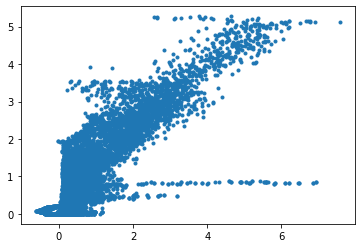

16169/16169 [==============================] - 4s 264us/sample - loss: 3.9919 - P_y_C_d_critic_loss: 4.6215 - P_y_C_d_predictor_loss: 0.3720 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1650 - P_y_C_l_critic_loss: 4.1911 - P_y_C_l_predictor_loss: 0.7325 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.2634 - P_d_C_l_critic_loss: 0.0985 - P_d_C_l_predictor_loss: 0.4564 - P_l_C_d_critic_loss: 9.2366 - P_l_C_d_predictor_loss: 0.1866 - val_loss: 2.6160 - val_P_y_C_d_critic_loss: 4.8508 - val_P_y_C_d_predictor_loss: 0.3159 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0891 - val_P_y_C_l_critic_loss: 1.7316 - val_P_y_C_l_predictor_loss: 0.5185 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2232 - val_P_d_C_l_critic_loss: 0.0911 - val_P_d_C_l_predictor_loss: 0.3748 - val_P_l_C_d_critic_loss: 3.3864 - val_P_l_C_d_predictor_loss: 0.0881
Epoch 3/100
16169/16169 [==============================] - 3s 204us/sample - loss: 

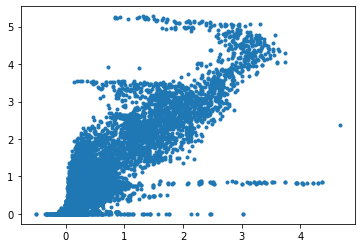

16169/16169 [==============================] - 4s 264us/sample - loss: 2.8878 - P_y_C_d_critic_loss: 2.1297 - P_y_C_d_predictor_loss: 0.3875 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0854 - P_y_C_l_critic_loss: 2.6749 - P_y_C_l_predictor_loss: 0.6074 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3309 - P_d_C_l_critic_loss: 0.0959 - P_d_C_l_predictor_loss: 0.4106 - P_l_C_d_critic_loss: 3.8434 - P_l_C_d_predictor_loss: 0.1928 - val_loss: 2.6414 - val_P_y_C_d_critic_loss: 1.4404 - val_P_y_C_d_predictor_loss: 0.3421 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0622 - val_P_y_C_l_critic_loss: 5.4036 - val_P_y_C_l_predictor_loss: 0.6131 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.3223 - val_P_d_C_l_critic_loss: 0.0615 - val_P_d_C_l_predictor_loss: 0.3224 - val_P_l_C_d_critic_loss: 1.1982 - val_P_l_C_d_predictor_loss: 0.1688
Epoch 5/100
16169/16169 [==============================] - 3s 193us/sample - loss: 

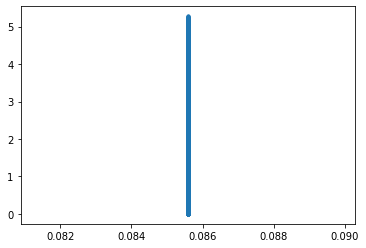

16169/16169 [==============================] - 4s 264us/sample - loss: 13.0084 - P_y_C_d_critic_loss: 27.0273 - P_y_C_d_predictor_loss: 0.6949 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0873 - P_y_C_l_critic_loss: 26.6552 - P_y_C_l_predictor_loss: 0.6484 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 2.2103 - P_d_C_l_critic_loss: 0.7221 - P_d_C_l_predictor_loss: 1.5415 - P_l_C_d_critic_loss: 8.1318 - P_l_C_d_predictor_loss: 1.6008 - val_loss: 14.4187 - val_P_y_C_d_critic_loss: 6.5743 - val_P_y_C_d_predictor_loss: 0.6455 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0684 - val_P_y_C_l_critic_loss: 46.4204 - val_P_y_C_l_predictor_loss: 0.6394 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 2.2667 - val_P_d_C_l_critic_loss: 1.7453 - val_P_d_C_l_predictor_loss: 0.9540 - val_P_l_C_d_critic_loss: 6.3246 - val_P_l_C_d_predictor_loss: 3.7353
Epoch 7/100
16169/16169 [==============================] - 3s 194us/sample - l

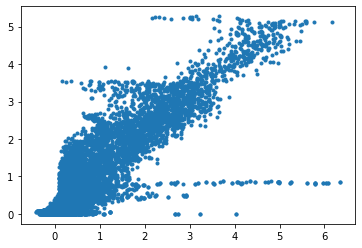

16169/16169 [==============================] - 4s 266us/sample - loss: 277.3166 - P_y_C_d_critic_loss: 3.9527 - P_y_C_d_predictor_loss: 0.6620 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.3225 - P_y_C_l_critic_loss: 1350.2756 - P_y_C_l_predictor_loss: 0.7447 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 8.6311 - P_d_C_l_critic_loss: 309.6079 - P_d_C_l_predictor_loss: 4.5062 - P_l_C_d_critic_loss: 720.8929 - P_l_C_d_predictor_loss: 23.5354 - val_loss: 19.0587 - val_P_y_C_d_critic_loss: 2.6561 - val_P_y_C_d_predictor_loss: 0.6270 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0887 - val_P_y_C_l_critic_loss: 32.7282 - val_P_y_C_l_predictor_loss: 0.6259 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.4516 - val_P_d_C_l_critic_loss: 24.6317 - val_P_d_C_l_predictor_loss: 2.6673 - val_P_l_C_d_critic_loss: 74.7116 - val_P_l_C_d_predictor_loss: 1.1249
Epoch 9/100
15800/16169 [============================>.] - ETA: 0s - 

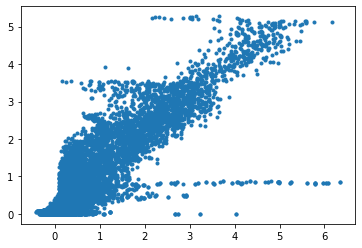

16169/16169 [==============================] - 4s 266us/sample - loss: 3.2454 - P_y_C_d_critic_loss: 2.6229 - P_y_C_d_predictor_loss: 0.3597 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1139 - P_y_C_l_critic_loss: 6.1741 - P_y_C_l_predictor_loss: 0.6563 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3172 - P_d_C_l_critic_loss: 0.0823 - P_d_C_l_predictor_loss: 0.3755 - P_l_C_d_critic_loss: 3.9190 - P_l_C_d_predictor_loss: 0.1418 - val_loss: 2.0087 - val_P_y_C_d_critic_loss: 1.8077 - val_P_y_C_d_predictor_loss: 0.2949 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0765 - val_P_y_C_l_critic_loss: 1.0884 - val_P_y_C_l_predictor_loss: 0.5526 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2577 - val_P_d_C_l_critic_loss: 0.0560 - val_P_d_C_l_predictor_loss: 0.2928 - val_P_l_C_d_critic_loss: 1.7758 - val_P_l_C_d_predictor_loss: 0.0612
Epoch 11/100
16169/16169 [==============================] - 3s 203us/sample - loss:

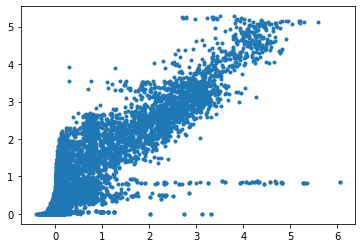

16169/16169 [==============================] - 4s 265us/sample - loss: 3.1687 - P_y_C_d_critic_loss: 2.1128 - P_y_C_d_predictor_loss: 0.3685 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1049 - P_y_C_l_critic_loss: 3.8202 - P_y_C_l_predictor_loss: 0.5723 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.5784 - P_d_C_l_critic_loss: 0.0830 - P_d_C_l_predictor_loss: 0.3765 - P_l_C_d_critic_loss: 4.0050 - P_l_C_d_predictor_loss: 0.1707 - val_loss: 4.4235 - val_P_y_C_d_critic_loss: 1.4959 - val_P_y_C_d_predictor_loss: 0.3271 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0716 - val_P_y_C_l_critic_loss: 16.8565 - val_P_y_C_l_predictor_loss: 0.5772 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.6021 - val_P_d_C_l_critic_loss: 0.0553 - val_P_d_C_l_predictor_loss: 0.2698 - val_P_l_C_d_critic_loss: 6.4090 - val_P_l_C_d_predictor_loss: 0.0934
Epoch 13/100
16169/16169 [==============================] - 3s 194us/sample - loss

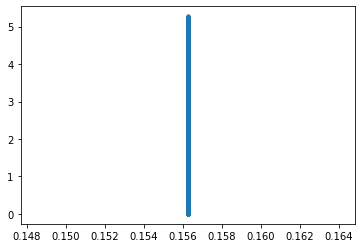

16169/16169 [==============================] - 4s 265us/sample - loss: 531.2370 - P_y_C_d_critic_loss: 566.8071 - P_y_C_d_predictor_loss: 1.3331 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 21.9519 - P_y_C_l_critic_loss: 2495.1428 - P_y_C_l_predictor_loss: 0.8341 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 20.9695 - P_d_C_l_critic_loss: 100.9613 - P_d_C_l_predictor_loss: 13.8262 - P_l_C_d_critic_loss: 523.4158 - P_l_C_d_predictor_loss: 117.8475 - val_loss: 5415.6102 - val_P_y_C_d_critic_loss: 4002.8127 - val_P_y_C_d_predictor_loss: 0.6290 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0591 - val_P_y_C_l_critic_loss: 32145.0605 - val_P_y_C_l_predictor_loss: 0.6245 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.3490 - val_P_d_C_l_critic_loss: 3612.1606 - val_P_d_C_l_predictor_loss: 2.8095 - val_P_l_C_d_critic_loss: 3707.3013 - val_P_l_C_d_predictor_loss: 1064.1584
Epoch 15/100
16169/16169 [======================

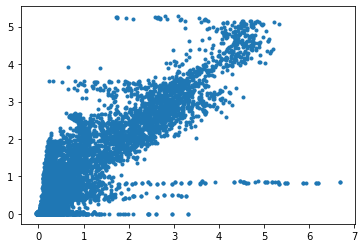

16169/16169 [==============================] - 4s 266us/sample - loss: 86.4908 - P_y_C_d_critic_loss: 184.6481 - P_y_C_d_predictor_loss: 2.1898 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 1.3367 - P_y_C_l_critic_loss: 79.6786 - P_y_C_l_predictor_loss: 0.6010 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 2.4726 - P_d_C_l_critic_loss: 13.6767 - P_d_C_l_predictor_loss: 2.7682 - P_l_C_d_critic_loss: 481.3457 - P_l_C_d_predictor_loss: 1.4242 - val_loss: 138.7999 - val_P_y_C_d_critic_loss: 98.2173 - val_P_y_C_d_predictor_loss: 0.6231 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.3869 - val_P_y_C_l_critic_loss: 67.2157 - val_P_y_C_l_predictor_loss: 0.6227 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.6024 - val_P_d_C_l_critic_loss: 18.2971 - val_P_d_C_l_predictor_loss: 2.6059 - val_P_l_C_d_critic_loss: 1145.6655 - val_P_l_C_d_predictor_loss: 1.0034
Epoch 17/100
16169/16169 [==============================] - 3s 195us

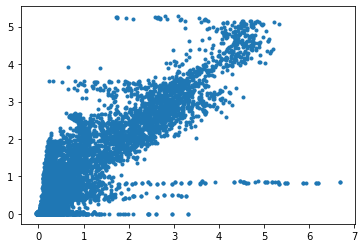

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8198 - P_y_C_d_critic_loss: 2.3945 - P_y_C_d_predictor_loss: 0.3577 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1178 - P_y_C_l_critic_loss: 3.5165 - P_y_C_l_predictor_loss: 0.5938 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3771 - P_d_C_l_critic_loss: 0.0798 - P_d_C_l_predictor_loss: 0.3575 - P_l_C_d_critic_loss: 2.8960 - P_l_C_d_predictor_loss: 0.1280 - val_loss: 2.0299 - val_P_y_C_d_critic_loss: 2.3978 - val_P_y_C_d_predictor_loss: 0.2999 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0771 - val_P_y_C_l_critic_loss: 0.8917 - val_P_y_C_l_predictor_loss: 0.5584 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2818 - val_P_d_C_l_critic_loss: 0.0557 - val_P_d_C_l_predictor_loss: 0.2784 - val_P_l_C_d_critic_loss: 1.4416 - val_P_l_C_d_predictor_loss: 0.0554
Epoch 19/100
16169/16169 [==============================] - 3s 195us/sample - loss:

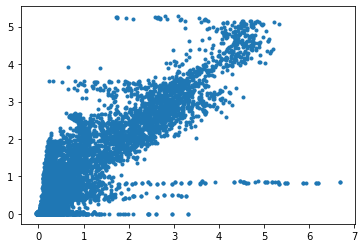

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8927 - P_y_C_d_critic_loss: 2.7112 - P_y_C_d_predictor_loss: 0.3715 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1175 - P_y_C_l_critic_loss: 3.7678 - P_y_C_l_predictor_loss: 0.5914 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3750 - P_d_C_l_critic_loss: 0.0775 - P_d_C_l_predictor_loss: 0.3605 - P_l_C_d_critic_loss: 2.8980 - P_l_C_d_predictor_loss: 0.1313 - val_loss: 2.1464 - val_P_y_C_d_critic_loss: 2.5045 - val_P_y_C_d_predictor_loss: 0.3221 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0760 - val_P_y_C_l_critic_loss: 1.8111 - val_P_y_C_l_predictor_loss: 0.5575 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2819 - val_P_d_C_l_critic_loss: 0.0542 - val_P_d_C_l_predictor_loss: 0.2759 - val_P_l_C_d_critic_loss: 1.4122 - val_P_l_C_d_predictor_loss: 0.0546
Epoch 21/100
16169/16169 [==============================] - 3s 194us/sample - loss:

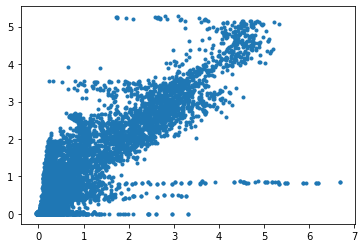

16169/16169 [==============================] - 4s 267us/sample - loss: 2.8843 - P_y_C_d_critic_loss: 2.7540 - P_y_C_d_predictor_loss: 0.3668 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1179 - P_y_C_l_critic_loss: 3.7872 - P_y_C_l_predictor_loss: 0.5896 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3721 - P_d_C_l_critic_loss: 0.0784 - P_d_C_l_predictor_loss: 0.3601 - P_l_C_d_critic_loss: 2.8906 - P_l_C_d_predictor_loss: 0.1269 - val_loss: 2.2105 - val_P_y_C_d_critic_loss: 3.3720 - val_P_y_C_d_predictor_loss: 0.3115 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0759 - val_P_y_C_l_critic_loss: 1.7576 - val_P_y_C_l_predictor_loss: 0.5558 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2781 - val_P_d_C_l_critic_loss: 0.0557 - val_P_d_C_l_predictor_loss: 0.2759 - val_P_l_C_d_critic_loss: 1.4048 - val_P_l_C_d_predictor_loss: 0.0541
Epoch 23/100
16169/16169 [==============================] - 3s 195us/sample - loss:

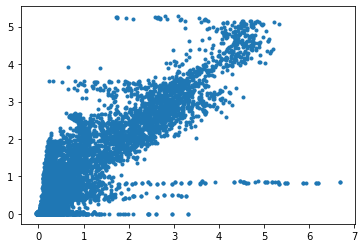

16169/16169 [==============================] - 4s 267us/sample - loss: 2.9406 - P_y_C_d_critic_loss: 3.1129 - P_y_C_d_predictor_loss: 0.3768 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1176 - P_y_C_l_critic_loss: 3.8023 - P_y_C_l_predictor_loss: 0.5921 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3733 - P_d_C_l_critic_loss: 0.0786 - P_d_C_l_predictor_loss: 0.3589 - P_l_C_d_critic_loss: 2.9102 - P_l_C_d_predictor_loss: 0.1319 - val_loss: 2.4406 - val_P_y_C_d_critic_loss: 5.5389 - val_P_y_C_d_predictor_loss: 0.3189 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0759 - val_P_y_C_l_critic_loss: 1.6558 - val_P_y_C_l_predictor_loss: 0.5635 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2809 - val_P_d_C_l_critic_loss: 0.0544 - val_P_d_C_l_predictor_loss: 0.2751 - val_P_l_C_d_critic_loss: 1.4241 - val_P_l_C_d_predictor_loss: 0.0587
Epoch 25/100
16169/16169 [==============================] - 3s 195us/sample - loss:

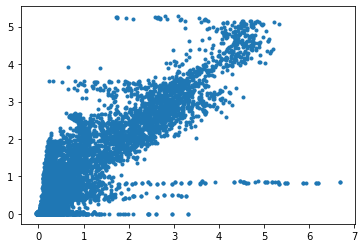

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8842 - P_y_C_d_critic_loss: 2.7059 - P_y_C_d_predictor_loss: 0.3665 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1173 - P_y_C_l_critic_loss: 3.8337 - P_y_C_l_predictor_loss: 0.5853 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3750 - P_d_C_l_critic_loss: 0.0781 - P_d_C_l_predictor_loss: 0.3573 - P_l_C_d_critic_loss: 2.8564 - P_l_C_d_predictor_loss: 0.1355 - val_loss: 2.1608 - val_P_y_C_d_critic_loss: 3.0140 - val_P_y_C_d_predictor_loss: 0.2991 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0755 - val_P_y_C_l_critic_loss: 1.6437 - val_P_y_C_l_predictor_loss: 0.5496 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2811 - val_P_d_C_l_critic_loss: 0.0547 - val_P_d_C_l_predictor_loss: 0.2855 - val_P_l_C_d_critic_loss: 1.4033 - val_P_l_C_d_predictor_loss: 0.0582
Epoch 27/100
16169/16169 [==============================] - 3s 195us/sample - loss:

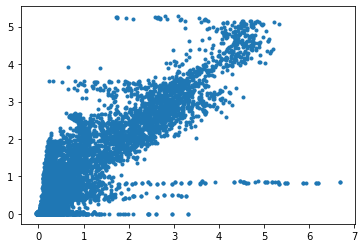

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8472 - P_y_C_d_critic_loss: 2.4567 - P_y_C_d_predictor_loss: 0.3559 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1170 - P_y_C_l_critic_loss: 3.8028 - P_y_C_l_predictor_loss: 0.5862 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3761 - P_d_C_l_critic_loss: 0.0754 - P_d_C_l_predictor_loss: 0.3539 - P_l_C_d_critic_loss: 2.9170 - P_l_C_d_predictor_loss: 0.1329 - val_loss: 2.0808 - val_P_y_C_d_critic_loss: 1.9324 - val_P_y_C_d_predictor_loss: 0.3007 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0762 - val_P_y_C_l_critic_loss: 1.6295 - val_P_y_C_l_predictor_loss: 0.5744 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2938 - val_P_d_C_l_critic_loss: 0.0551 - val_P_d_C_l_predictor_loss: 0.2827 - val_P_l_C_d_critic_loss: 1.3714 - val_P_l_C_d_predictor_loss: 0.0540
Epoch 29/100
16169/16169 [==============================] - 3s 195us/sample - loss:

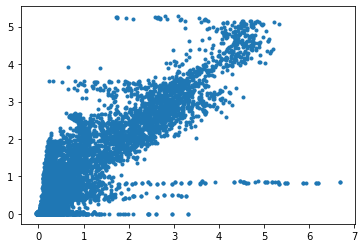

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8408 - P_y_C_d_critic_loss: 2.4187 - P_y_C_d_predictor_loss: 0.3579 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1171 - P_y_C_l_critic_loss: 3.8764 - P_y_C_l_predictor_loss: 0.5834 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3714 - P_d_C_l_critic_loss: 0.0798 - P_d_C_l_predictor_loss: 0.3546 - P_l_C_d_critic_loss: 2.8456 - P_l_C_d_predictor_loss: 0.1341 - val_loss: 2.0382 - val_P_y_C_d_critic_loss: 1.8590 - val_P_y_C_d_predictor_loss: 0.2899 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0757 - val_P_y_C_l_critic_loss: 1.5816 - val_P_y_C_l_predictor_loss: 0.5703 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2776 - val_P_d_C_l_critic_loss: 0.0545 - val_P_d_C_l_predictor_loss: 0.2832 - val_P_l_C_d_critic_loss: 1.3550 - val_P_l_C_d_predictor_loss: 0.0563
Epoch 31/100
16169/16169 [==============================] - 3s 194us/sample - loss:

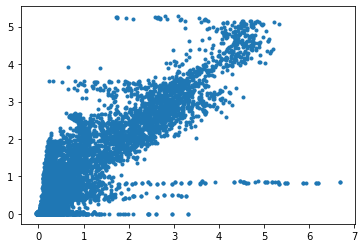

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8470 - P_y_C_d_critic_loss: 2.3863 - P_y_C_d_predictor_loss: 0.3574 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1164 - P_y_C_l_critic_loss: 3.8044 - P_y_C_l_predictor_loss: 0.5927 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3760 - P_d_C_l_critic_loss: 0.0765 - P_d_C_l_predictor_loss: 0.3559 - P_l_C_d_critic_loss: 2.8630 - P_l_C_d_predictor_loss: 0.1351 - val_loss: 2.0170 - val_P_y_C_d_critic_loss: 1.7961 - val_P_y_C_d_predictor_loss: 0.2853 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0751 - val_P_y_C_l_critic_loss: 1.5374 - val_P_y_C_l_predictor_loss: 0.5636 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2807 - val_P_d_C_l_critic_loss: 0.0545 - val_P_d_C_l_predictor_loss: 0.2837 - val_P_l_C_d_critic_loss: 1.3411 - val_P_l_C_d_predictor_loss: 0.0555
Epoch 33/100
16169/16169 [==============================] - 3s 195us/sample - loss:

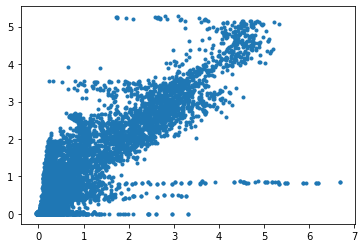

16169/16169 [==============================] - 4s 267us/sample - loss: 2.8233 - P_y_C_d_critic_loss: 2.4262 - P_y_C_d_predictor_loss: 0.3524 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1155 - P_y_C_l_critic_loss: 3.7584 - P_y_C_l_predictor_loss: 0.5844 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3723 - P_d_C_l_critic_loss: 0.0751 - P_d_C_l_predictor_loss: 0.3507 - P_l_C_d_critic_loss: 2.8678 - P_l_C_d_predictor_loss: 0.1354 - val_loss: 2.0267 - val_P_y_C_d_critic_loss: 1.9251 - val_P_y_C_d_predictor_loss: 0.2925 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0756 - val_P_y_C_l_critic_loss: 1.4888 - val_P_y_C_l_predictor_loss: 0.5456 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2894 - val_P_d_C_l_critic_loss: 0.0553 - val_P_d_C_l_predictor_loss: 0.2880 - val_P_l_C_d_critic_loss: 1.3197 - val_P_l_C_d_predictor_loss: 0.0564
Epoch 35/100
16169/16169 [==============================] - 3s 195us/sample - loss:

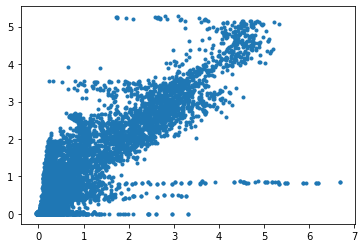

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8507 - P_y_C_d_critic_loss: 2.4704 - P_y_C_d_predictor_loss: 0.3568 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1163 - P_y_C_l_critic_loss: 3.7770 - P_y_C_l_predictor_loss: 0.5886 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3741 - P_d_C_l_critic_loss: 0.0865 - P_d_C_l_predictor_loss: 0.3664 - P_l_C_d_critic_loss: 2.8402 - P_l_C_d_predictor_loss: 0.1309 - val_loss: 2.1098 - val_P_y_C_d_critic_loss: 2.6578 - val_P_y_C_d_predictor_loss: 0.3103 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0746 - val_P_y_C_l_critic_loss: 1.3769 - val_P_y_C_l_predictor_loss: 0.5687 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2876 - val_P_d_C_l_critic_loss: 0.0544 - val_P_d_C_l_predictor_loss: 0.2736 - val_P_l_C_d_critic_loss: 1.3047 - val_P_l_C_d_predictor_loss: 0.0554
Epoch 37/100
16169/16169 [==============================] - 3s 195us/sample - loss:

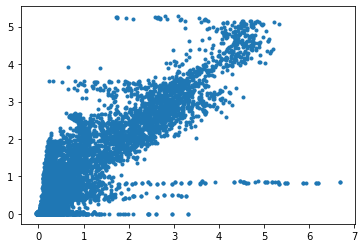

16169/16169 [==============================] - 4s 267us/sample - loss: 2.8414 - P_y_C_d_critic_loss: 2.4843 - P_y_C_d_predictor_loss: 0.3617 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1152 - P_y_C_l_critic_loss: 3.8376 - P_y_C_l_predictor_loss: 0.5839 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3711 - P_d_C_l_critic_loss: 0.0781 - P_d_C_l_predictor_loss: 0.3551 - P_l_C_d_critic_loss: 2.8497 - P_l_C_d_predictor_loss: 0.1296 - val_loss: 2.0499 - val_P_y_C_d_critic_loss: 1.9219 - val_P_y_C_d_predictor_loss: 0.3104 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0754 - val_P_y_C_l_critic_loss: 1.4730 - val_P_y_C_l_predictor_loss: 0.5624 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2878 - val_P_d_C_l_critic_loss: 0.0536 - val_P_d_C_l_predictor_loss: 0.2800 - val_P_l_C_d_critic_loss: 1.3137 - val_P_l_C_d_predictor_loss: 0.0574
Epoch 39/100
16169/16169 [==============================] - 3s 195us/sample - loss:

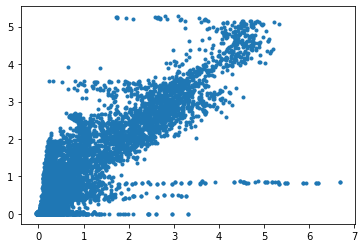

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8591 - P_y_C_d_critic_loss: 2.5128 - P_y_C_d_predictor_loss: 0.3588 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1151 - P_y_C_l_critic_loss: 3.8382 - P_y_C_l_predictor_loss: 0.5873 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3752 - P_d_C_l_critic_loss: 0.0795 - P_d_C_l_predictor_loss: 0.3639 - P_l_C_d_critic_loss: 2.8432 - P_l_C_d_predictor_loss: 0.1318 - val_loss: 2.0432 - val_P_y_C_d_critic_loss: 2.2939 - val_P_y_C_d_predictor_loss: 0.2878 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0742 - val_P_y_C_l_critic_loss: 1.5026 - val_P_y_C_l_predictor_loss: 0.5584 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2769 - val_P_d_C_l_critic_loss: 0.0547 - val_P_d_C_l_predictor_loss: 0.2732 - val_P_l_C_d_critic_loss: 1.3019 - val_P_l_C_d_predictor_loss: 0.0571
Epoch 41/100
16169/16169 [==============================] - 3s 196us/sample - loss:

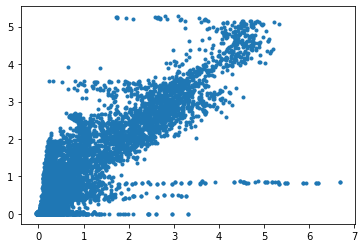

16169/16169 [==============================] - 4s 268us/sample - loss: 2.8903 - P_y_C_d_critic_loss: 2.8091 - P_y_C_d_predictor_loss: 0.3663 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1151 - P_y_C_l_critic_loss: 3.8059 - P_y_C_l_predictor_loss: 0.5889 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3719 - P_d_C_l_critic_loss: 0.0828 - P_d_C_l_predictor_loss: 0.3597 - P_l_C_d_critic_loss: 2.8262 - P_l_C_d_predictor_loss: 0.1364 - val_loss: 2.1983 - val_P_y_C_d_critic_loss: 3.6511 - val_P_y_C_d_predictor_loss: 0.3169 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0743 - val_P_y_C_l_critic_loss: 1.3061 - val_P_y_C_l_predictor_loss: 0.5602 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2856 - val_P_d_C_l_critic_loss: 0.0540 - val_P_d_C_l_predictor_loss: 0.2774 - val_P_l_C_d_critic_loss: 1.2734 - val_P_l_C_d_predictor_loss: 0.0552
Epoch 43/100
16169/16169 [==============================] - 3s 195us/sample - loss:

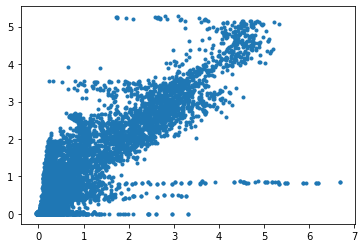

16169/16169 [==============================] - 4s 267us/sample - loss: 3.0097 - P_y_C_d_critic_loss: 3.7494 - P_y_C_d_predictor_loss: 0.3929 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1140 - P_y_C_l_critic_loss: 3.9859 - P_y_C_l_predictor_loss: 0.5838 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3727 - P_d_C_l_critic_loss: 0.0775 - P_d_C_l_predictor_loss: 0.3603 - P_l_C_d_critic_loss: 2.8011 - P_l_C_d_predictor_loss: 0.1256 - val_loss: 2.8128 - val_P_y_C_d_critic_loss: 8.6716 - val_P_y_C_d_predictor_loss: 0.4132 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0748 - val_P_y_C_l_critic_loss: 1.3978 - val_P_y_C_l_predictor_loss: 0.5703 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2839 - val_P_d_C_l_critic_loss: 0.0543 - val_P_d_C_l_predictor_loss: 0.2794 - val_P_l_C_d_critic_loss: 1.2380 - val_P_l_C_d_predictor_loss: 0.0548
Epoch 45/100
16169/16169 [==============================] - 3s 194us/sample - loss:

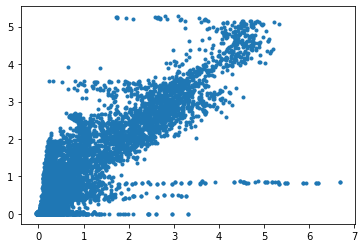

16169/16169 [==============================] - 4s 266us/sample - loss: 2.9477 - P_y_C_d_critic_loss: 3.1414 - P_y_C_d_predictor_loss: 0.3781 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1135 - P_y_C_l_critic_loss: 4.0466 - P_y_C_l_predictor_loss: 0.5850 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3685 - P_d_C_l_critic_loss: 0.0773 - P_d_C_l_predictor_loss: 0.3540 - P_l_C_d_critic_loss: 2.8098 - P_l_C_d_predictor_loss: 0.1414 - val_loss: 2.3922 - val_P_y_C_d_critic_loss: 5.1255 - val_P_y_C_d_predictor_loss: 0.3174 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0742 - val_P_y_C_l_critic_loss: 1.5345 - val_P_y_C_l_predictor_loss: 0.5884 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2853 - val_P_d_C_l_critic_loss: 0.0530 - val_P_d_C_l_predictor_loss: 0.2738 - val_P_l_C_d_critic_loss: 1.2373 - val_P_l_C_d_predictor_loss: 0.0576
Epoch 47/100
16169/16169 [==============================] - 3s 195us/sample - loss:

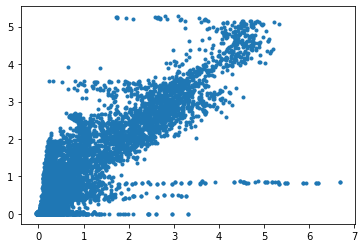

16169/16169 [==============================] - 4s 267us/sample - loss: 2.8868 - P_y_C_d_critic_loss: 2.8398 - P_y_C_d_predictor_loss: 0.3676 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1134 - P_y_C_l_critic_loss: 3.9742 - P_y_C_l_predictor_loss: 0.5800 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3727 - P_d_C_l_critic_loss: 0.0805 - P_d_C_l_predictor_loss: 0.3599 - P_l_C_d_critic_loss: 2.7643 - P_l_C_d_predictor_loss: 0.1270 - val_loss: 2.2271 - val_P_y_C_d_critic_loss: 3.7463 - val_P_y_C_d_predictor_loss: 0.3149 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0730 - val_P_y_C_l_critic_loss: 1.6120 - val_P_y_C_l_predictor_loss: 0.5696 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2735 - val_P_d_C_l_critic_loss: 0.0533 - val_P_d_C_l_predictor_loss: 0.2780 - val_P_l_C_d_critic_loss: 1.2188 - val_P_l_C_d_predictor_loss: 0.0549
Epoch 49/100
16169/16169 [==============================] - 3s 195us/sample - loss:

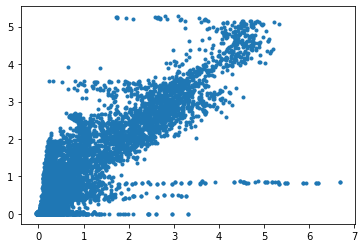

16169/16169 [==============================] - 4s 270us/sample - loss: 2.6894 - P_y_C_d_critic_loss: 2.5648 - P_y_C_d_predictor_loss: 0.3574 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1122 - P_y_C_l_critic_loss: 2.4402 - P_y_C_l_predictor_loss: 0.5802 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3661 - P_d_C_l_critic_loss: 0.0819 - P_d_C_l_predictor_loss: 0.3601 - P_l_C_d_critic_loss: 2.7746 - P_l_C_d_predictor_loss: 0.1273 - val_loss: 1.9722 - val_P_y_C_d_critic_loss: 2.6165 - val_P_y_C_d_predictor_loss: 0.3125 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0737 - val_P_y_C_l_critic_loss: 0.5206 - val_P_y_C_l_predictor_loss: 0.5369 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2792 - val_P_d_C_l_critic_loss: 0.0524 - val_P_d_C_l_predictor_loss: 0.2763 - val_P_l_C_d_critic_loss: 1.1981 - val_P_l_C_d_predictor_loss: 0.0547
Epoch 51/100
16169/16169 [==============================] - 3s 195us/sample - loss:

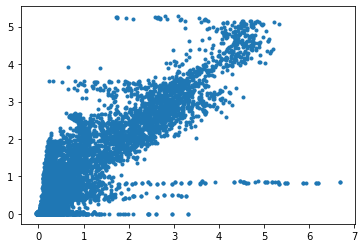

16169/16169 [==============================] - 4s 267us/sample - loss: 2.8579 - P_y_C_d_critic_loss: 2.3447 - P_y_C_d_predictor_loss: 0.3544 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1116 - P_y_C_l_critic_loss: 4.3674 - P_y_C_l_predictor_loss: 0.5857 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3690 - P_d_C_l_critic_loss: 0.0755 - P_d_C_l_predictor_loss: 0.3493 - P_l_C_d_critic_loss: 2.7650 - P_l_C_d_predictor_loss: 0.1326 - val_loss: 2.0650 - val_P_y_C_d_critic_loss: 1.7982 - val_P_y_C_d_predictor_loss: 0.2863 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0742 - val_P_y_C_l_critic_loss: 2.2407 - val_P_y_C_l_predictor_loss: 0.5630 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2797 - val_P_d_C_l_critic_loss: 0.0527 - val_P_d_C_l_predictor_loss: 0.2746 - val_P_l_C_d_critic_loss: 1.2037 - val_P_l_C_d_predictor_loss: 0.0573
Epoch 53/100
16169/16169 [==============================] - 3s 195us/sample - loss:

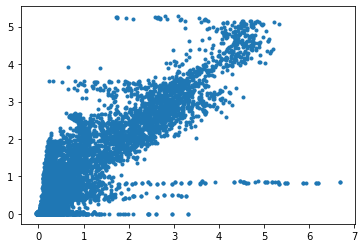

16169/16169 [==============================] - 4s 266us/sample - loss: 2.8861 - P_y_C_d_critic_loss: 2.3391 - P_y_C_d_predictor_loss: 0.3546 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1115 - P_y_C_l_critic_loss: 4.6463 - P_y_C_l_predictor_loss: 0.5872 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3677 - P_d_C_l_critic_loss: 0.0763 - P_d_C_l_predictor_loss: 0.3522 - P_l_C_d_critic_loss: 2.7560 - P_l_C_d_predictor_loss: 0.1319 - val_loss: 2.4552 - val_P_y_C_d_critic_loss: 1.7027 - val_P_y_C_d_predictor_loss: 0.2896 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0726 - val_P_y_C_l_critic_loss: 6.0602 - val_P_y_C_l_predictor_loss: 0.5968 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2647 - val_P_d_C_l_critic_loss: 0.0555 - val_P_d_C_l_predictor_loss: 0.2791 - val_P_l_C_d_critic_loss: 1.1597 - val_P_l_C_d_predictor_loss: 0.0543
Epoch 55/100
16169/16169 [==============================] - 3s 194us/sample - loss:

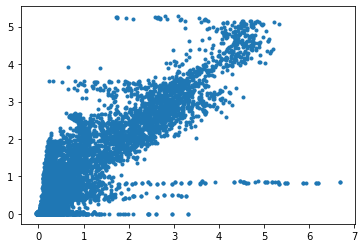

16169/16169 [==============================] - 4s 267us/sample - loss: 6.9043 - P_y_C_d_critic_loss: 2.3499 - P_y_C_d_predictor_loss: 0.3595 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1116 - P_y_C_l_critic_loss: 43.3132 - P_y_C_l_predictor_loss: 0.7203 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3609 - P_d_C_l_critic_loss: 0.0740 - P_d_C_l_predictor_loss: 0.3550 - P_l_C_d_critic_loss: 2.8351 - P_l_C_d_predictor_loss: 0.1364 - val_loss: 3.6226 - val_P_y_C_d_critic_loss: 1.8214 - val_P_y_C_d_predictor_loss: 0.2939 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0700 - val_P_y_C_l_critic_loss: 17.1240 - val_P_y_C_l_predictor_loss: 0.6401 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2761 - val_P_d_C_l_critic_loss: 0.0547 - val_P_d_C_l_predictor_loss: 0.2702 - val_P_l_C_d_critic_loss: 1.1312 - val_P_l_C_d_predictor_loss: 0.0586
Epoch 57/100
16169/16169 [==============================] - 3s 194us/sample - los

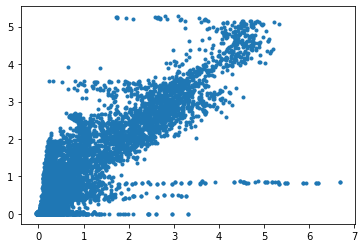

16169/16169 [==============================] - 4s 270us/sample - loss: 2.8038 - P_y_C_d_critic_loss: 2.3325 - P_y_C_d_predictor_loss: 0.3518 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1101 - P_y_C_l_critic_loss: 3.9480 - P_y_C_l_predictor_loss: 0.5815 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3657 - P_d_C_l_critic_loss: 0.0815 - P_d_C_l_predictor_loss: 0.3495 - P_l_C_d_critic_loss: 2.7339 - P_l_C_d_predictor_loss: 0.1360 - val_loss: 2.0049 - val_P_y_C_d_critic_loss: 1.7736 - val_P_y_C_d_predictor_loss: 0.3033 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0722 - val_P_y_C_l_critic_loss: 1.6862 - val_P_y_C_l_predictor_loss: 0.5630 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2844 - val_P_d_C_l_critic_loss: 0.0547 - val_P_d_C_l_predictor_loss: 0.2670 - val_P_l_C_d_critic_loss: 1.1161 - val_P_l_C_d_predictor_loss: 0.0518
Epoch 59/100
16169/16169 [==============================] - 3s 195us/sample - loss:

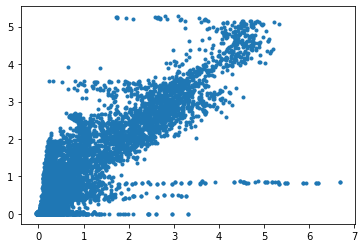

16169/16169 [==============================] - 4s 273us/sample - loss: 2.8227 - P_y_C_d_critic_loss: 2.3590 - P_y_C_d_predictor_loss: 0.3549 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1090 - P_y_C_l_critic_loss: 4.1743 - P_y_C_l_predictor_loss: 0.5795 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3650 - P_d_C_l_critic_loss: 0.0807 - P_d_C_l_predictor_loss: 0.3600 - P_l_C_d_critic_loss: 2.6996 - P_l_C_d_predictor_loss: 0.1230 - val_loss: 2.0373 - val_P_y_C_d_critic_loss: 1.8847 - val_P_y_C_d_predictor_loss: 0.2844 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0711 - val_P_y_C_l_critic_loss: 2.0860 - val_P_y_C_l_predictor_loss: 0.5568 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2735 - val_P_d_C_l_critic_loss: 0.0522 - val_P_d_C_l_predictor_loss: 0.2782 - val_P_l_C_d_critic_loss: 1.1246 - val_P_l_C_d_predictor_loss: 0.0584
Epoch 61/100
16169/16169 [==============================] - 3s 195us/sample - loss:

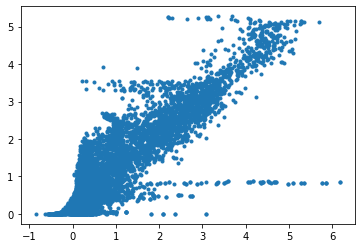

16169/16169 [==============================] - 4s 275us/sample - loss: 2.8550 - P_y_C_d_critic_loss: 2.2853 - P_y_C_d_predictor_loss: 0.3568 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1078 - P_y_C_l_critic_loss: 4.4427 - P_y_C_l_predictor_loss: 0.5808 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3623 - P_d_C_l_critic_loss: 0.0787 - P_d_C_l_predictor_loss: 0.3596 - P_l_C_d_critic_loss: 2.7270 - P_l_C_d_predictor_loss: 0.1339 - val_loss: 2.1308 - val_P_y_C_d_critic_loss: 1.7575 - val_P_y_C_d_predictor_loss: 0.2746 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0705 - val_P_y_C_l_critic_loss: 3.1692 - val_P_y_C_l_predictor_loss: 0.5687 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2723 - val_P_d_C_l_critic_loss: 0.0546 - val_P_d_C_l_predictor_loss: 0.2791 - val_P_l_C_d_critic_loss: 1.1068 - val_P_l_C_d_predictor_loss: 0.0566
Epoch 63/100
16169/16169 [==============================] - 3s 199us/sample - loss:

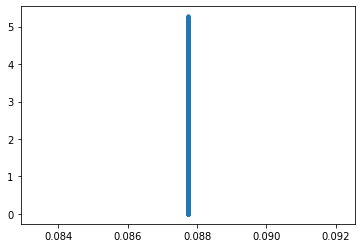

16169/16169 [==============================] - 4s 265us/sample - loss: 9.3372 - P_y_C_d_critic_loss: 18.7311 - P_y_C_d_predictor_loss: 0.9182 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0902 - P_y_C_l_critic_loss: 46.0100 - P_y_C_l_predictor_loss: 0.6467 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3666 - P_d_C_l_critic_loss: 0.0653 - P_d_C_l_predictor_loss: 0.3194 - P_l_C_d_critic_loss: 2.9934 - P_l_C_d_predictor_loss: 0.2166 - val_loss: 3.5880 - val_P_y_C_d_critic_loss: 10.3664 - val_P_y_C_d_predictor_loss: 0.6448 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0691 - val_P_y_C_l_critic_loss: 5.4839 - val_P_y_C_l_predictor_loss: 0.6235 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2763 - val_P_d_C_l_critic_loss: 0.0444 - val_P_d_C_l_predictor_loss: 0.2517 - val_P_l_C_d_critic_loss: 0.7687 - val_P_l_C_d_predictor_loss: 0.0561
Epoch 65/100
16169/16169 [==============================] - 3s 194us/sample - lo

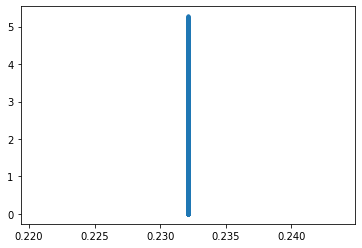

16169/16169 [==============================] - 4s 265us/sample - loss: 12.6856 - P_y_C_d_critic_loss: 76.8591 - P_y_C_d_predictor_loss: 0.8526 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.2821 - P_y_C_l_critic_loss: 18.6638 - P_y_C_l_predictor_loss: 0.6079 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.4627 - P_d_C_l_critic_loss: 0.0680 - P_d_C_l_predictor_loss: 0.2847 - P_l_C_d_critic_loss: 3.8896 - P_l_C_d_predictor_loss: 0.2515 - val_loss: 6.6111 - val_P_y_C_d_critic_loss: 39.3258 - val_P_y_C_d_predictor_loss: 0.6227 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0621 - val_P_y_C_l_critic_loss: 5.0277 - val_P_y_C_l_predictor_loss: 0.6227 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.3122 - val_P_d_C_l_critic_loss: 0.0478 - val_P_d_C_l_predictor_loss: 0.2395 - val_P_l_C_d_critic_loss: 2.3459 - val_P_l_C_d_predictor_loss: 0.0768
Epoch 67/100
16169/16169 [==============================] - 3s 195us/sample - l

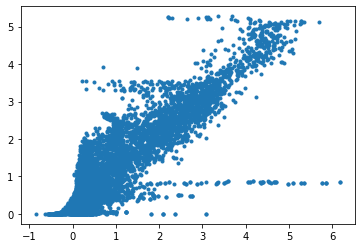

16169/16169 [==============================] - 4s 266us/sample - loss: 10.1258 - P_y_C_d_critic_loss: 12.6686 - P_y_C_d_predictor_loss: 0.6889 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.1045 - P_y_C_l_critic_loss: 63.5774 - P_y_C_l_predictor_loss: 0.6407 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3573 - P_d_C_l_critic_loss: 0.0688 - P_d_C_l_predictor_loss: 0.3393 - P_l_C_d_critic_loss: 2.5672 - P_l_C_d_predictor_loss: 0.1484 - val_loss: 33.0634 - val_P_y_C_d_critic_loss: 27.2918 - val_P_y_C_d_predictor_loss: 0.7169 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0712 - val_P_y_C_l_critic_loss: 282.0871 - val_P_y_C_l_predictor_loss: 0.6449 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2453 - val_P_d_C_l_critic_loss: 0.0581 - val_P_d_C_l_predictor_loss: 0.2884 - val_P_l_C_d_critic_loss: 0.9096 - val_P_l_C_d_predictor_loss: 0.0641
Epoch 69/100
16169/16169 [==============================] - 3s 195us/sample 

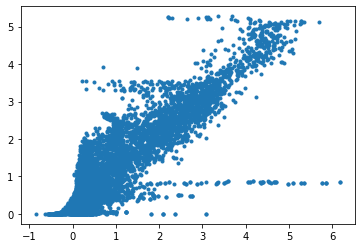

16169/16169 [==============================] - 4s 268us/sample - loss: 6.6456 - P_y_C_d_critic_loss: 12.3014 - P_y_C_d_predictor_loss: 0.6198 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0894 - P_y_C_l_critic_loss: 30.9832 - P_y_C_l_predictor_loss: 0.5879 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3403 - P_d_C_l_critic_loss: 0.0728 - P_d_C_l_predictor_loss: 0.3259 - P_l_C_d_critic_loss: 2.4092 - P_l_C_d_predictor_loss: 0.1210 - val_loss: 14.8439 - val_P_y_C_d_critic_loss: 13.5938 - val_P_y_C_d_predictor_loss: 0.5933 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0671 - val_P_y_C_l_critic_loss: 115.4430 - val_P_y_C_l_predictor_loss: 0.6304 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2401 - val_P_d_C_l_critic_loss: 0.0533 - val_P_d_C_l_predictor_loss: 0.2620 - val_P_l_C_d_critic_loss: 0.9033 - val_P_l_C_d_predictor_loss: 0.0521
Epoch 71/100
16169/16169 [==============================] - 3s 195us/sample -

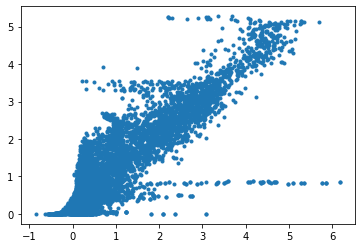

16169/16169 [==============================] - 4s 267us/sample - loss: 11.8313 - P_y_C_d_critic_loss: 10.1036 - P_y_C_d_predictor_loss: 0.5791 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0887 - P_y_C_l_critic_loss: 83.7154 - P_y_C_l_predictor_loss: 0.6596 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3376 - P_d_C_l_critic_loss: 0.0743 - P_d_C_l_predictor_loss: 0.3341 - P_l_C_d_critic_loss: 2.7516 - P_l_C_d_predictor_loss: 0.1636 - val_loss: 7.9730 - val_P_y_C_d_critic_loss: 13.1784 - val_P_y_C_d_predictor_loss: 0.6928 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0655 - val_P_y_C_l_critic_loss: 45.9359 - val_P_y_C_l_predictor_loss: 0.6269 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2509 - val_P_d_C_l_critic_loss: 0.0546 - val_P_d_C_l_predictor_loss: 0.2641 - val_P_l_C_d_critic_loss: 0.9415 - val_P_l_C_d_predictor_loss: 0.0607
Epoch 73/100
16169/16169 [==============================] - 3s 196us/sample - 

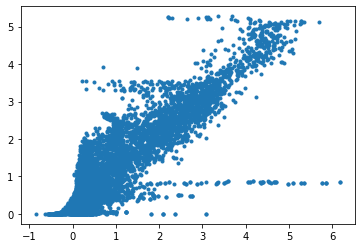

16169/16169 [==============================] - 4s 268us/sample - loss: 11.6195 - P_y_C_d_critic_loss: 8.6153 - P_y_C_d_predictor_loss: 0.5335 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0882 - P_y_C_l_critic_loss: 84.7491 - P_y_C_l_predictor_loss: 0.6468 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3384 - P_d_C_l_critic_loss: 0.0683 - P_d_C_l_predictor_loss: 0.3275 - P_l_C_d_critic_loss: 2.5419 - P_l_C_d_predictor_loss: 0.1309 - val_loss: 32.4417 - val_P_y_C_d_critic_loss: 11.9930 - val_P_y_C_d_predictor_loss: 0.5479 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0667 - val_P_y_C_l_critic_loss: 293.4951 - val_P_y_C_l_predictor_loss: 0.6323 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2294 - val_P_d_C_l_critic_loss: 0.0590 - val_P_d_C_l_predictor_loss: 0.2567 - val_P_l_C_d_critic_loss: 0.9248 - val_P_l_C_d_predictor_loss: 0.0631
Epoch 75/100
16169/16169 [==============================] - 3s 195us/sample -

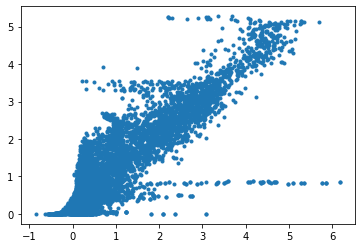

16169/16169 [==============================] - 4s 267us/sample - loss: 5.3601 - P_y_C_d_critic_loss: 9.4107 - P_y_C_d_predictor_loss: 0.5394 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0871 - P_y_C_l_critic_loss: 20.8562 - P_y_C_l_predictor_loss: 0.6082 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3896 - P_d_C_l_critic_loss: 0.0707 - P_d_C_l_predictor_loss: 0.3260 - P_l_C_d_critic_loss: 2.4414 - P_l_C_d_predictor_loss: 0.1311 - val_loss: 3.5975 - val_P_y_C_d_critic_loss: 11.3770 - val_P_y_C_d_predictor_loss: 0.5065 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0654 - val_P_y_C_l_critic_loss: 5.7129 - val_P_y_C_l_predictor_loss: 0.6129 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2982 - val_P_d_C_l_critic_loss: 0.0512 - val_P_d_C_l_predictor_loss: 0.2521 - val_P_l_C_d_critic_loss: 0.9547 - val_P_l_C_d_predictor_loss: 0.0524
Epoch 77/100
16169/16169 [==============================] - 3s 195us/sample - los

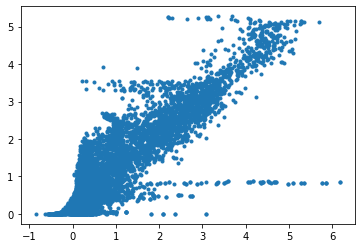

16169/16169 [==============================] - 4s 267us/sample - loss: 8.7516 - P_y_C_d_critic_loss: 7.8845 - P_y_C_d_predictor_loss: 0.4727 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0866 - P_y_C_l_critic_loss: 57.4244 - P_y_C_l_predictor_loss: 0.6295 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3403 - P_d_C_l_critic_loss: 0.0764 - P_d_C_l_predictor_loss: 0.3341 - P_l_C_d_critic_loss: 2.4592 - P_l_C_d_predictor_loss: 0.1333 - val_loss: 23.2275 - val_P_y_C_d_critic_loss: 14.4906 - val_P_y_C_d_predictor_loss: 0.5271 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0655 - val_P_y_C_l_critic_loss: 198.5623 - val_P_y_C_l_predictor_loss: 0.6440 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2361 - val_P_d_C_l_critic_loss: 0.0612 - val_P_d_C_l_predictor_loss: 0.3002 - val_P_l_C_d_critic_loss: 0.8746 - val_P_l_C_d_predictor_loss: 0.0567
Epoch 79/100
16169/16169 [==============================] - 3s 195us/sample - 

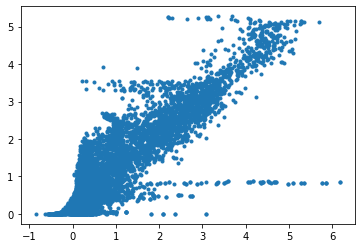

16169/16169 [==============================] - 4s 267us/sample - loss: 4.9804 - P_y_C_d_critic_loss: 8.2304 - P_y_C_d_predictor_loss: 0.4996 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0852 - P_y_C_l_critic_loss: 19.2346 - P_y_C_l_predictor_loss: 0.6035 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3376 - P_d_C_l_critic_loss: 0.0737 - P_d_C_l_predictor_loss: 0.3276 - P_l_C_d_critic_loss: 2.4737 - P_l_C_d_predictor_loss: 0.1247 - val_loss: 3.3767 - val_P_y_C_d_critic_loss: 11.4319 - val_P_y_C_d_predictor_loss: 0.5995 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0643 - val_P_y_C_l_critic_loss: 3.5786 - val_P_y_C_l_predictor_loss: 0.5895 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2357 - val_P_d_C_l_critic_loss: 0.0498 - val_P_d_C_l_predictor_loss: 0.2426 - val_P_l_C_d_critic_loss: 0.8918 - val_P_l_C_d_predictor_loss: 0.0496
Epoch 81/100
16169/16169 [==============================] - 3s 195us/sample - los

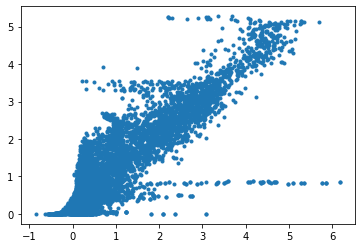

16169/16169 [==============================] - 4s 267us/sample - loss: 7.8883 - P_y_C_d_critic_loss: 7.8102 - P_y_C_d_predictor_loss: 0.4761 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0848 - P_y_C_l_critic_loss: 49.1203 - P_y_C_l_predictor_loss: 0.6075 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3360 - P_d_C_l_critic_loss: 0.0688 - P_d_C_l_predictor_loss: 0.3265 - P_l_C_d_critic_loss: 2.4186 - P_l_C_d_predictor_loss: 0.1420 - val_loss: 19.4022 - val_P_y_C_d_critic_loss: 13.9746 - val_P_y_C_d_predictor_loss: 0.7336 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0654 - val_P_y_C_l_critic_loss: 159.3730 - val_P_y_C_l_predictor_loss: 0.6261 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2325 - val_P_d_C_l_critic_loss: 0.0603 - val_P_d_C_l_predictor_loss: 0.2635 - val_P_l_C_d_critic_loss: 0.8379 - val_P_l_C_d_predictor_loss: 0.0573
Epoch 83/100
16169/16169 [==============================] - 3s 195us/sample - 

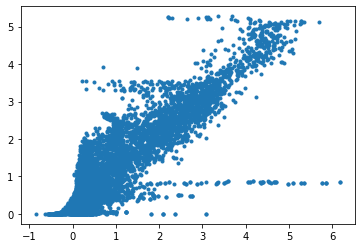

16169/16169 [==============================] - 4s 266us/sample - loss: 12.5850 - P_y_C_d_critic_loss: 9.5208 - P_y_C_d_predictor_loss: 0.5610 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0850 - P_y_C_l_critic_loss: 92.3863 - P_y_C_l_predictor_loss: 0.6466 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3351 - P_d_C_l_critic_loss: 0.0759 - P_d_C_l_predictor_loss: 0.3325 - P_l_C_d_critic_loss: 2.6696 - P_l_C_d_predictor_loss: 0.1737 - val_loss: 18.4596 - val_P_y_C_d_critic_loss: 11.0075 - val_P_y_C_d_predictor_loss: 0.6422 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0644 - val_P_y_C_l_critic_loss: 153.4952 - val_P_y_C_l_predictor_loss: 0.6294 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2226 - val_P_d_C_l_critic_loss: 0.0684 - val_P_d_C_l_predictor_loss: 0.2747 - val_P_l_C_d_critic_loss: 0.9704 - val_P_l_C_d_predictor_loss: 0.0731
Epoch 85/100
16169/16169 [==============================] - 3s 195us/sample -

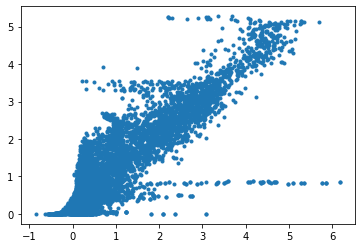

16169/16169 [==============================] - 4s 266us/sample - loss: 4.4626 - P_y_C_d_critic_loss: 6.4636 - P_y_C_d_predictor_loss: 0.4408 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0835 - P_y_C_l_critic_loss: 17.2097 - P_y_C_l_predictor_loss: 0.5630 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3327 - P_d_C_l_critic_loss: 0.0722 - P_d_C_l_predictor_loss: 0.3268 - P_l_C_d_critic_loss: 2.2883 - P_l_C_d_predictor_loss: 0.1201 - val_loss: 8.2031 - val_P_y_C_d_critic_loss: 9.6407 - val_P_y_C_d_predictor_loss: 0.5185 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0652 - val_P_y_C_l_critic_loss: 54.4566 - val_P_y_C_l_predictor_loss: 0.5802 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2343 - val_P_d_C_l_critic_loss: 0.0526 - val_P_d_C_l_predictor_loss: 0.2553 - val_P_l_C_d_critic_loss: 0.8590 - val_P_l_C_d_predictor_loss: 0.0489
Epoch 87/100
16169/16169 [==============================] - 3s 194us/sample - los

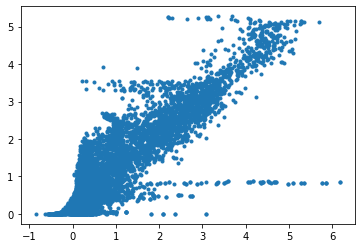

16169/16169 [==============================] - 4s 266us/sample - loss: 11.0289 - P_y_C_d_critic_loss: 7.8844 - P_y_C_d_predictor_loss: 0.5166 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0832 - P_y_C_l_critic_loss: 79.4051 - P_y_C_l_predictor_loss: 0.6312 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3336 - P_d_C_l_critic_loss: 0.0718 - P_d_C_l_predictor_loss: 0.3326 - P_l_C_d_critic_loss: 2.5764 - P_l_C_d_predictor_loss: 0.1650 - val_loss: 28.0892 - val_P_y_C_d_critic_loss: 13.4147 - val_P_y_C_d_predictor_loss: 0.5843 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0643 - val_P_y_C_l_critic_loss: 248.3212 - val_P_y_C_l_predictor_loss: 0.6296 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2228 - val_P_d_C_l_critic_loss: 0.0565 - val_P_d_C_l_predictor_loss: 0.2569 - val_P_l_C_d_critic_loss: 0.8929 - val_P_l_C_d_predictor_loss: 0.0644
Epoch 89/100
16169/16169 [==============================] - 3s 195us/sample -

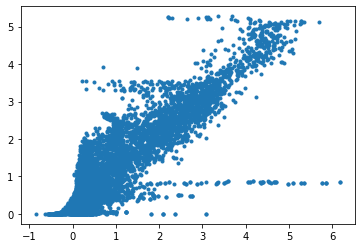

16169/16169 [==============================] - 4s 267us/sample - loss: 6.1956 - P_y_C_d_critic_loss: 8.1474 - P_y_C_d_predictor_loss: 0.5236 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0824 - P_y_C_l_critic_loss: 31.2019 - P_y_C_l_predictor_loss: 0.6038 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3344 - P_d_C_l_critic_loss: 0.0698 - P_d_C_l_predictor_loss: 0.3286 - P_l_C_d_critic_loss: 2.4244 - P_l_C_d_predictor_loss: 0.1397 - val_loss: 4.8325 - val_P_y_C_d_critic_loss: 10.5104 - val_P_y_C_d_predictor_loss: 0.5571 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0633 - val_P_y_C_l_critic_loss: 19.1115 - val_P_y_C_l_predictor_loss: 0.6347 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2248 - val_P_d_C_l_critic_loss: 0.0479 - val_P_d_C_l_predictor_loss: 0.2528 - val_P_l_C_d_critic_loss: 0.7996 - val_P_l_C_d_predictor_loss: 0.0525
Epoch 91/100
16169/16169 [==============================] - 3s 196us/sample - lo

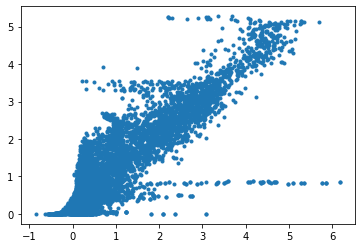

16169/16169 [==============================] - 4s 266us/sample - loss: 10.9254 - P_y_C_d_critic_loss: 16.4151 - P_y_C_d_predictor_loss: 0.7744 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0819 - P_y_C_l_critic_loss: 67.7708 - P_y_C_l_predictor_loss: 0.6247 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3280 - P_d_C_l_critic_loss: 0.0712 - P_d_C_l_predictor_loss: 0.3264 - P_l_C_d_critic_loss: 2.4894 - P_l_C_d_predictor_loss: 0.1508 - val_loss: 26.9865 - val_P_y_C_d_critic_loss: 17.3184 - val_P_y_C_d_predictor_loss: 0.6724 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0642 - val_P_y_C_l_critic_loss: 232.1707 - val_P_y_C_l_predictor_loss: 0.6340 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2369 - val_P_d_C_l_critic_loss: 0.0632 - val_P_d_C_l_predictor_loss: 0.2776 - val_P_l_C_d_critic_loss: 0.8146 - val_P_l_C_d_predictor_loss: 0.0660
Epoch 93/100
16169/16169 [==============================] - 3s 195us/sample 

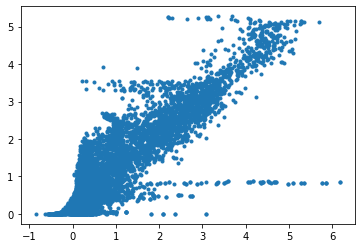

16169/16169 [==============================] - 4s 266us/sample - loss: 6.7452 - P_y_C_d_critic_loss: 16.2735 - P_y_C_d_predictor_loss: 0.8078 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0809 - P_y_C_l_critic_loss: 25.6592 - P_y_C_l_predictor_loss: 0.6052 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3323 - P_d_C_l_critic_loss: 0.0717 - P_d_C_l_predictor_loss: 0.3257 - P_l_C_d_critic_loss: 2.5326 - P_l_C_d_predictor_loss: 0.1405 - val_loss: 4.6730 - val_P_y_C_d_critic_loss: 12.5960 - val_P_y_C_d_predictor_loss: 0.6780 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0633 - val_P_y_C_l_critic_loss: 14.2160 - val_P_y_C_l_predictor_loss: 0.6271 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2303 - val_P_d_C_l_critic_loss: 0.0502 - val_P_d_C_l_predictor_loss: 0.2524 - val_P_l_C_d_critic_loss: 0.8521 - val_P_l_C_d_predictor_loss: 0.0500
Epoch 95/100
16169/16169 [==============================] - 3s 195us/sample - l

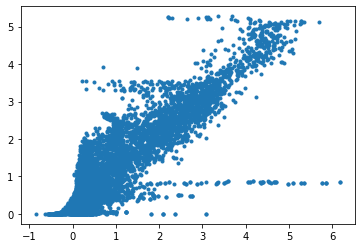

16169/16169 [==============================] - 4s 267us/sample - loss: 10.0004 - P_y_C_d_critic_loss: 10.1551 - P_y_C_d_predictor_loss: 0.6273 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0806 - P_y_C_l_critic_loss: 66.2844 - P_y_C_l_predictor_loss: 0.6232 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3275 - P_d_C_l_critic_loss: 0.0711 - P_d_C_l_predictor_loss: 0.3305 - P_l_C_d_critic_loss: 2.4970 - P_l_C_d_predictor_loss: 0.1450 - val_loss: 26.7929 - val_P_y_C_d_critic_loss: 13.0737 - val_P_y_C_d_predictor_loss: 0.6333 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0637 - val_P_y_C_l_critic_loss: 235.1524 - val_P_y_C_l_predictor_loss: 0.6343 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2213 - val_P_d_C_l_critic_loss: 0.0606 - val_P_d_C_l_predictor_loss: 0.2715 - val_P_l_C_d_critic_loss: 0.7593 - val_P_l_C_d_predictor_loss: 0.0657
Epoch 97/100
16169/16169 [==============================] - 3s 195us/sample 

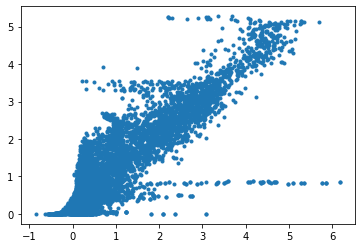

16169/16169 [==============================] - 4s 267us/sample - loss: 21.3037 - P_y_C_d_critic_loss: 28.0238 - P_y_C_d_predictor_loss: 0.8812 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0822 - P_y_C_l_critic_loss: 156.4598 - P_y_C_l_predictor_loss: 0.6774 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3261 - P_d_C_l_critic_loss: 0.0826 - P_d_C_l_predictor_loss: 0.3440 - P_l_C_d_critic_loss: 3.1159 - P_l_C_d_predictor_loss: 0.2278 - val_loss: 14.7422 - val_P_y_C_d_critic_loss: 31.6352 - val_P_y_C_d_predictor_loss: 0.6606 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0629 - val_P_y_C_l_critic_loss: 95.4043 - val_P_y_C_l_predictor_loss: 0.6287 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2371 - val_P_d_C_l_critic_loss: 0.0600 - val_P_d_C_l_predictor_loss: 0.2699 - val_P_l_C_d_critic_loss: 0.9174 - val_P_l_C_d_predictor_loss: 0.0789
Epoch 99/100
16169/16169 [==============================] - 3s 195us/sample 

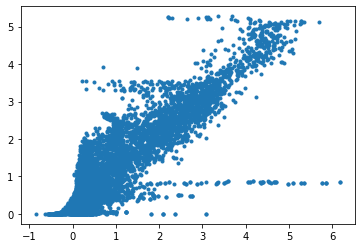

16169/16169 [==============================] - 4s 266us/sample - loss: 14.7681 - P_y_C_d_critic_loss: 13.7708 - P_y_C_d_predictor_loss: 0.7046 - P_d_C_y_critic_loss: 0.0000e+00 - P_d_C_y_predictor_loss: 0.0804 - P_y_C_l_critic_loss: 107.8035 - P_y_C_l_predictor_loss: 0.6656 - P_l_C_y_critic_loss: 0.0000e+00 - P_l_C_y_predictor_loss: 0.3235 - P_d_C_l_critic_loss: 0.0753 - P_d_C_l_predictor_loss: 0.3371 - P_l_C_d_critic_loss: 2.9406 - P_l_C_d_predictor_loss: 0.2082 - val_loss: 14.9786 - val_P_y_C_d_critic_loss: 24.7763 - val_P_y_C_d_predictor_loss: 0.6820 - val_P_d_C_y_critic_loss: 0.0000e+00 - val_P_d_C_y_predictor_loss: 0.0621 - val_P_y_C_l_critic_loss: 103.5369 - val_P_y_C_l_predictor_loss: 0.6287 - val_P_l_C_y_critic_loss: 0.0000e+00 - val_P_l_C_y_predictor_loss: 0.2571 - val_P_d_C_l_critic_loss: 0.0792 - val_P_d_C_l_predictor_loss: 0.2935 - val_P_l_C_d_critic_loss: 0.8634 - val_P_l_C_d_predictor_loss: 0.1279
Epoch 00100: early stopping


In [388]:

epochs = 100; #training_parameters["nepochs"]

batchsize =200;
if (tf.__version__ == '2.1.0'):
    confusion_matrix = tf.compat.v1.math.confusion_matrix
else:
    from tensorflow.math import confusion_matrix
    
import tensorflow.keras as keras
from tensorflow.keras import layers 

LRATE_MIN = 0.0001;
LRATE_MAX = 0.001;
BURNIN_EPOCHS = 10;

model_filepath = "discadv_models/model_test_closs0.1.h5"

closs = 0.1;

def _loss_from_name(n_):
    if 'critic' in n_:
        return closs
    else:
        return 1.

def _loss_noadv(n_):
    if 'P_y_C_d_predictor' != n_:
        return 0.
    else:
        return 1.
    
loss_weight_dict = {k: _loss_from_name(k) for k in losses.keys() }
#loss_weight_dict = {k: _loss_noadv(k) for k in losses.keys() }

monitor_loss = 'val_P_y_C_d_predictor_loss'

es = keras.callbacks.EarlyStopping(monitor=monitor_loss , mode='min', verbose=1, patience=5, restore_best_weights = True)
checkpointing = keras.callbacks.ModelCheckpoint(model_filepath , monitor = monitor_loss, mode = 'min', save_best_only = True)
model_opt = keras.optimizers.Adam(learning_rate=0.0);

target_predictions = [];
        
class plot_fit(tf.keras.callbacks.Callback):
    def __init__(self):
        self.y_output_index = [i for i,l in enumerate(disc_adv.outputs) if 'P_y_C_d_predictor' in l.name][0]
        None
        
    def on_epoch_end(self,epoch, logs = None):
        if (epoch+1) % 2 == 0:
            
            yhat = disc_adv.predict(x_train, batch_size = batchsize)
            pplot.cla()
            
            pplot.plot(yhat[self.y_output_index], y_train,'.')
            pplot.show()
            
        yhat_target = disc_adv.predict(X_target_experiments, batch_size = batchsize )
        target_predictions.append(yhat_target[2])
        
class BurnIn(tf.keras.callbacks.Callback):
    def __init__(self, burnin_epochs = None, lrate_max = LRATE_MAX):
        self.learning_rate = lrate_max
        self.burnin_epochs = burnin_epochs
        
    def on_epoch_end(self,epoch, logs = None):
        if epoch <= self.burnin_epochs:
            de = epoch/self.burnin_epochs
            lrate = de * self.learning_rate
            if lrate < LRATE_MIN:
                model_opt.learning_rate = LRATE_MIN
            else:
                model_opt.learning_rate = de * self.learning_rate
                print("----- setting learning rate to %2.4f"%(de * self.learning_rate))


loss_fcn = losses


# GOAL: Maximize the loss of the domain critic while maximizing the actual predictor.
# useful discriminator:
disc_adv.compile(optimizer =  model_opt,
              loss =loss_fcn,
              loss_weights = loss_weight_dict)

train_in, train_out = data_to_input_dict(X = x_train, y = y_train, d = d_train, l = c_train)
test_in, test_out = data_to_input_dict(X = x_test, y = y_test, d = d_test, l = c_test)

burnin = BurnIn(burnin_epochs = BURNIN_EPOCHS, lrate_max = LRATE_MAX)
history_d = disc_adv.fit(train_in, train_out, epochs=epochs,
                     batch_size=batchsize,
                      validation_data = [test_in, test_out],# "Rc_output" :  RemCTest}],
                     callbacks=[es, burnin, plot_fit(), checkpointing])#, Top3AccStrong()])#, InspectActivations()]);#, Top3AccStrong()])




In [30]:
h = history_d.history;
h.update({"target_predictions" : target_predictions})
asdf =pd.DataFrame(h)

NameError: name 'history_d' is not defined

In [31]:
#pplot.plot(h['loss']);pplot.plot(h['val_loss'])
pplot.semilogy(h['P_y_C_d_predictor_loss'])
pplot.semilogy(h['P_y_C_d_critic_loss'])

NameError: name 'h' is not defined

In [32]:
for k,v in zip(h.keys(), h.values()) :
    if "loss" in k:
        if "predic" in k:
            pplot.plot(v, label = k)
        pplot.ylim([0,2])
    
#pplot.legend()

NameError: name 'h' is not defined

In [33]:

disc_adv.load_weights("discadv_models/model_test.h5")


ValueError: You are trying to load a weight file containing 19 layers into a model with 25 layers.

In [34]:
res = disc_adv.predict(X_target_experiments)
#np.sum(np.argmax(res[-1],1)==np.argmax(cond_oh_target,1))/cond_oh_target.shape[0]

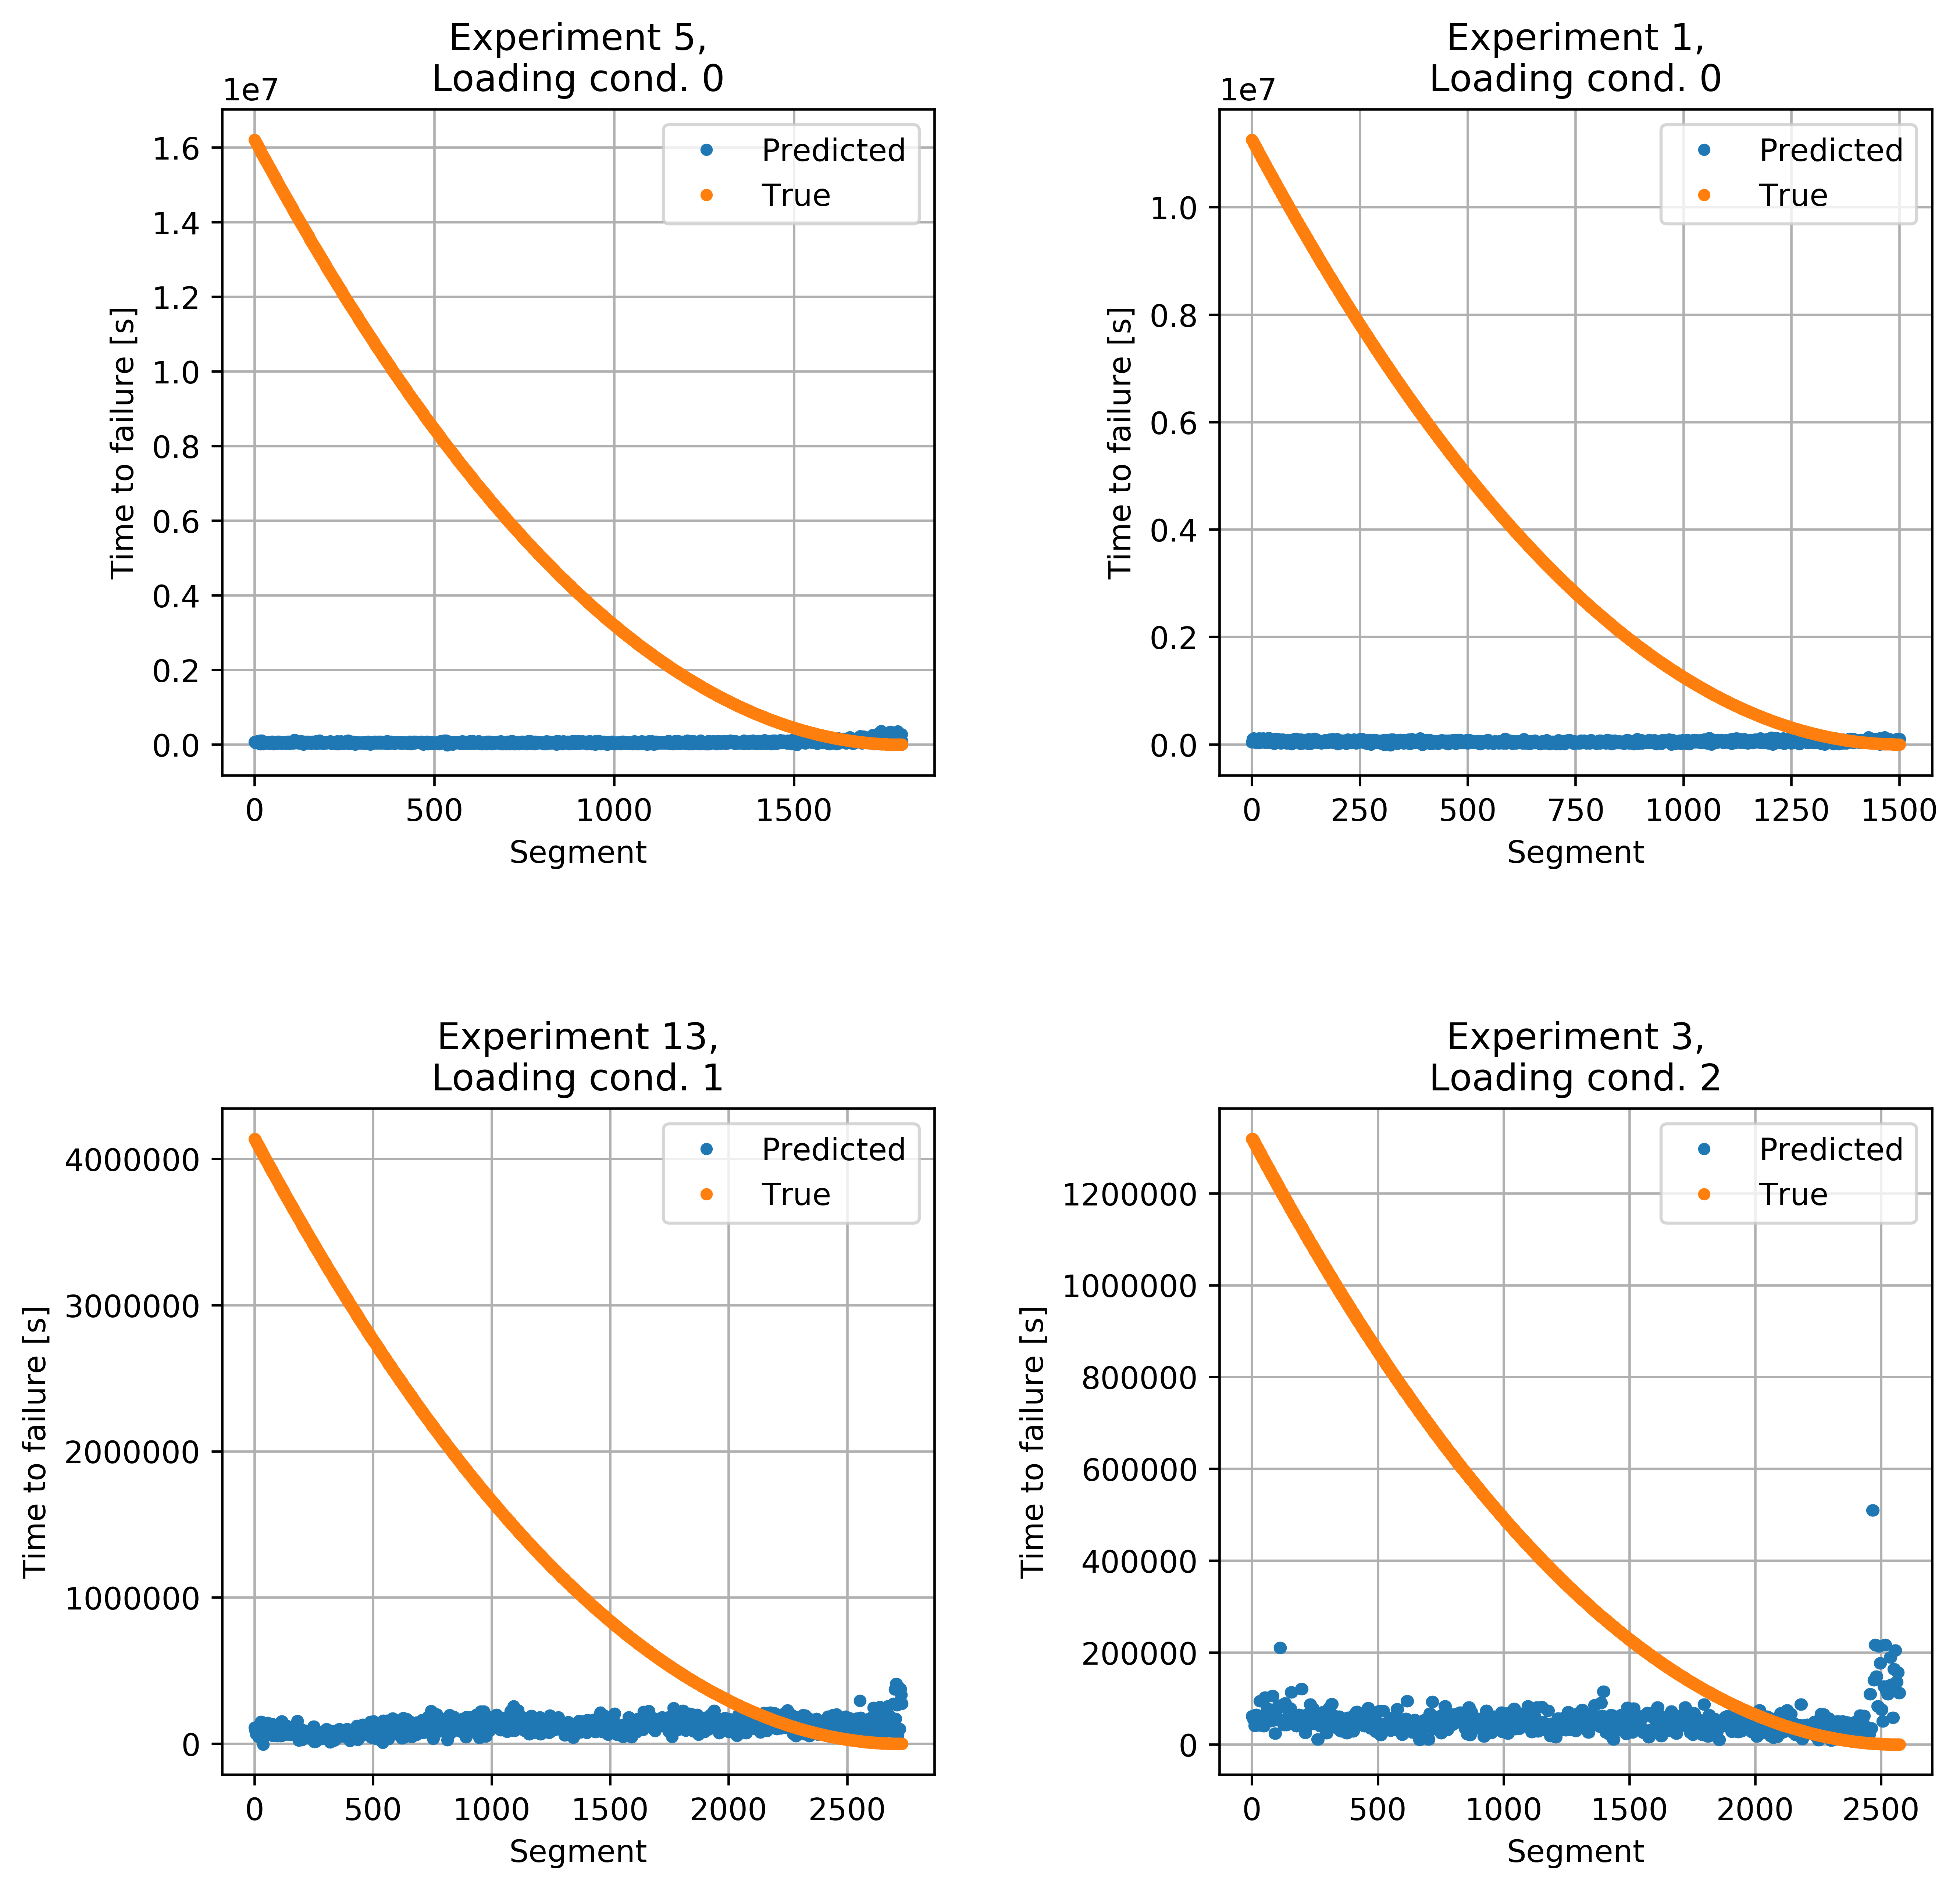

In [35]:
#res[1].shape
y_output_index = [i for i,l in enumerate(disc_adv.outputs) if 'P_y_C_d_predictor' in l.name][0]
#[l for l in locals() if 'target' in l]
#pplot.plot(res[y_output_index],yrem_norm_target,'.')
# Plot experiments separately:
yrem_std = np.std(yrem);
pplot.figure(figsize=(10,10), dpi = 600)
for m,k in enumerate(inds_exp_target):#enumerate(np.unique(np.argmax(eid_oh_target,1))): #[l for l in locals() if 'target' in l]
    pplot.subplot(2,2,m+1)
    ids_cur =np.argmax(eid_oh_target ,1) == k
    loading_conds_ids = np.unique(np.argmax(cond_oh_target[ids_cur],1))
    
    val = yrem_std * res[y_output_index][ids_cur].flatten()
    #val = np.convolve(val, np.array([1,1,1,1,1,1])/6., 'same').flatten();
    pplot.plot(val,'.', label = "Predicted")
    #pplot.plot(yrem_std * res[y_output_index][ids_cur],'.', label = "Predicted")
    pplot.plot(yrem_std * yrem_norm_target[ids_cur],'.', label = "True")
    #pplot.ylim([0,3e7])
    if k == 13:
        None
        #pplot.ylim([0,1.0e7])
    if k == 3:
        None
        #pplot.ylim([0,1.0e7])
    pplot.title("Experiment %i,\nLoading cond. %i"%(k,loading_conds_ids[0]))
    pplot.ylabel("Time to failure [s]")
    pplot.xlabel("Segment")
    pplot.grid()
    pplot.legend()

pplot.subplots_adjust(wspace = 0.4, hspace = 0.5)
pplot.savefig("cnn_target_closs0.1.png")



In [279]:
res_source = disc_adv.predict(X_source_experiments)

In [280]:
PdCl = keras.Model(disc_adv.input , disc_adv.get_layer("P_y_C_d").output)
res_source_emb =PdCl.predict(X_source_experiments, batch_size = 50)

In [285]:
from sklearn.decomposition import PCA
pplot.figure(figsize = (10,10))
ypca = PCA(n_components= 5).fit_transform(res_source_emb);
#from sklearn.manifold import TSNE
#ysne = TSNE(n_components=2,verbose = 2).fit_transform(res_source_emb);


<Figure size 720x720 with 0 Axes>

In [286]:
ysne.shape,X_source_experiments.shape

((21559, 2), (21559, 2559, 2))

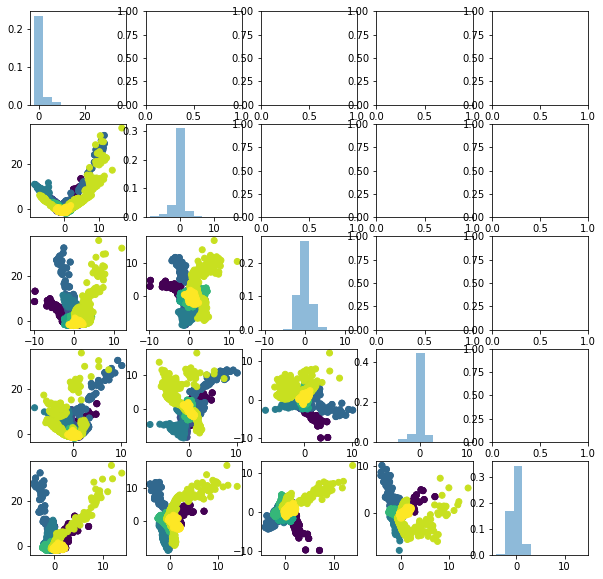

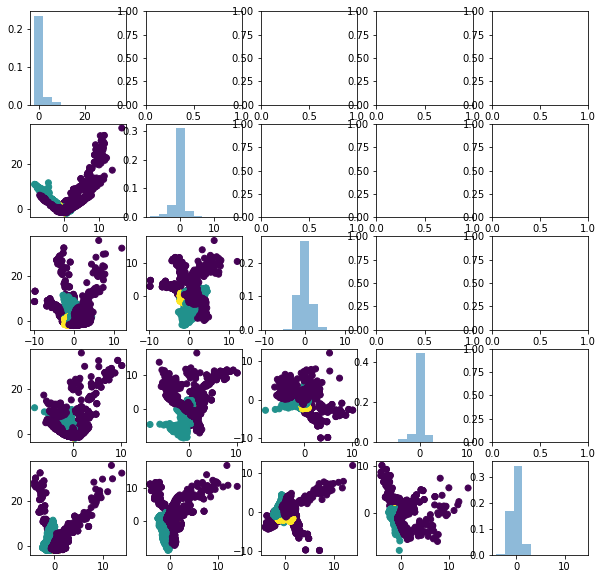

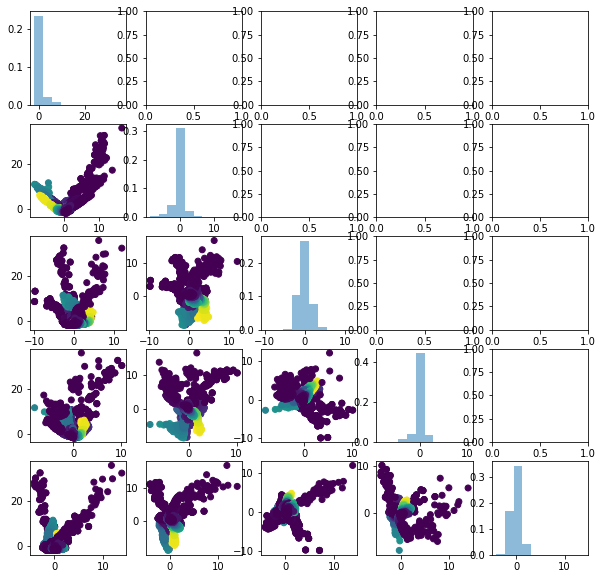

In [317]:
def plot_pca_comps(ypca_val, col_val):
    k_ = 1;
    for i in range(ypca_val.shape[1]):
        for j in range(ypca_val.shape[1]):
            
            pplot.subplot(ypca_val.shape[1],ypca_val.shape[1],k_)
            k_ += 1;
            if i == j:
                pplot.hist(ypca_val[:,i], 10,alpha = 0.5, density= True)
            if i>j:
                pplot.scatter(ypca_val[:,i],ypca_val[:,j], c = col_val)
    
pplot.figure(figsize = (10,10))
plot_pca_comps(ypca,np.argmax(eid_oh_source,1))

pplot.show()
pplot.figure(figsize = (10,10))
plot_pca_comps(ypca,np.argmax(cond_oh_source,1))

pplot.show()
pplot.figure(figsize = (10,10))
plot_pca_comps(ypca,yrem_norm_source)


In [163]:
from ipywidgets import FloatSlider, interact, interactive
#[l for l in locals() if "source" in l]
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

@interact(theta =  FloatSlider(min = 0, max = 6.28),theta2 =  FloatSlider(min = 0, max = 6.28),theta3 =  FloatSlider(min = 0, max = 6.28) )
def pltrot(theta, theta2, theta3):
    #v = [v1, v2, v3]
    axis = [0, 1, 0]
    r = rotation_matrix(axis, theta)
    yr = np.dot(ysne,r)
    
    axis = [0, 0, 1]
    r = rotation_matrix(axis, theta2)
    yr = np.dot(yr,r)
    
    axis = [1, 0, 0]
    r = rotation_matrix(axis, theta3)
    yr = np.dot(yr,r)
    
    print(yr.shape)
    #pplot.plot(ysne[:,0],ysne[:,1],'.')
    
    pplot.subplot(1,2,1)
    pplot.scatter(yr[::10,0], yr[::10,1],c = np.argmax(cond_oh_source,1)[::10])
    pplot.subplot(1,2,2)
    pplot.scatter(yr[::10,1], yr[::10,2],c = np.argmax(cond_oh_source,1)[::10])

interactive(children=(FloatSlider(value=0.0, description='theta', max=6.28), FloatSlider(value=0.0, descriptio…

In [318]:
# vin = keras.layers.Input(shape = (2))
# out = Dense(2, use_bias = False, activation = "softmax")(vin)
# m_proj = keras.Model(outputs = out, inputs = vin)
# m_proj.compile(loss = 'categorical_crossentropy', optimizer = 'Adam')
# m_proj.fit(ysne, cond_oh_source, epochs= 10)
res_source = disc_adv.predict(X_source_experiments)


loading conds:  [0]
loading conds:  [0]
loading conds:  [0]
loading conds:  [0]
loading conds:  [0]
loading conds:  [1]
loading conds:  [1]
loading conds:  [1]
loading conds:  [2]


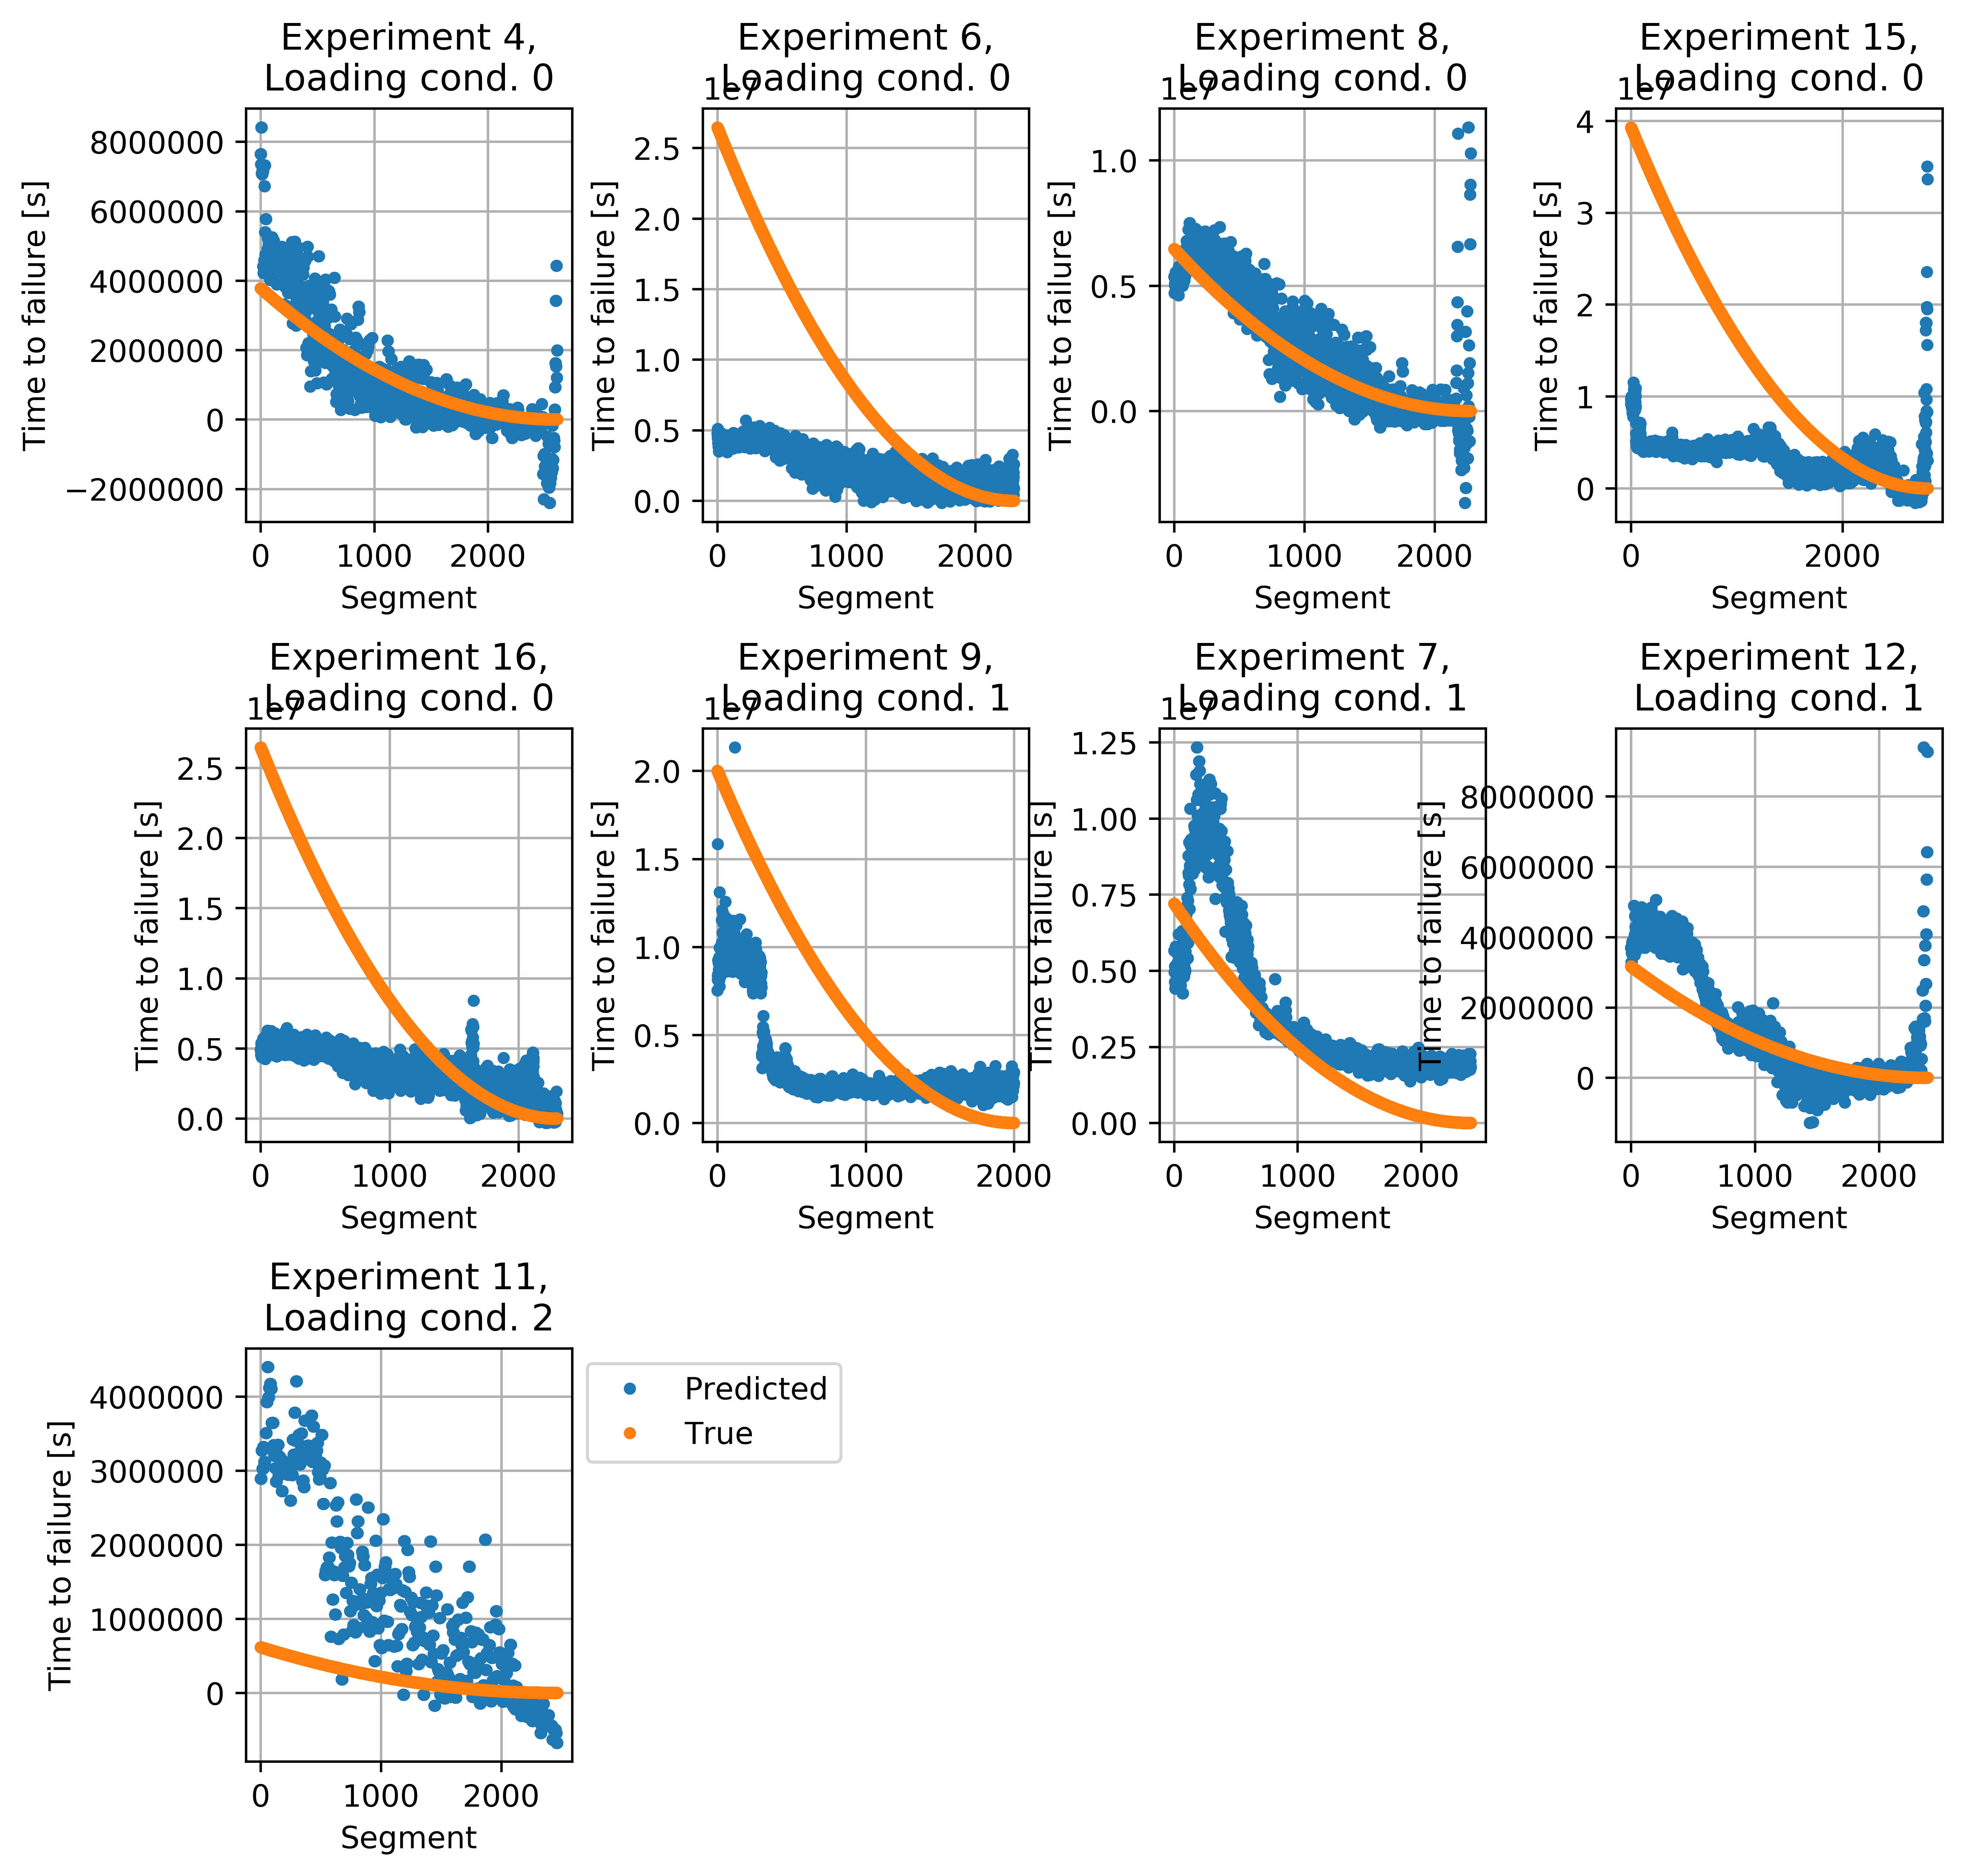

In [406]:
#res[1].shape
y_output_index = [i for i,l in enumerate(disc_adv.outputs) if 'P_y_C_d_predictor' in l.name][0]
#[l for l in locals() if 'target' in l]
#pplot.plot(res[y_output_index],yrem_norm_target,'.')
# Plot experiments separately:
yrem_std = np.std(yrem);
pplot.figure(figsize=(10,10), dpi = 600)
for m,k in enumerate(inds_exp_source): #[l for l in locals() if 'target' in l]
    pplot.subplot(3,4,m+1)
    ids_cur =np.argmax(eid_oh_source ,1) == k
    loading_conds_ids = np.unique(np.argmax(cond_oh_source[ids_cur],1))
    print("loading conds: " , loading_conds_ids)
    val = yrem_std * res_source[y_output_index][ids_cur].flatten()
    
    pplot.plot(val,'.', label = "Predicted")
    pplot.plot(yrem_std * yrem_norm_source[ids_cur],'.', label = "True")
    pplot.title("Experiment %i,\nLoading cond. %i"%(k,loading_conds_ids[0]))
    pplot.ylabel("Time to failure [s]")
    pplot.xlabel("Segment")
    pplot.grid()

pplot.legend(loc="upper left", bbox_to_anchor=(1,1))


pplot.subplots_adjust(wspace = 0.4, hspace = 0.5)
    

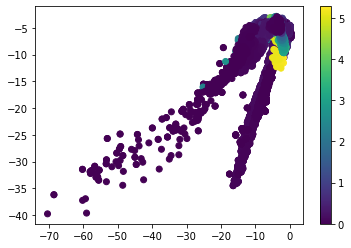

In [169]:
res_source_y  = res_source [0]
pplot.scatter(res_source_y[:,0],res_source_y[:,1],c = yrem_norm_source);pplot.colorbar()

In [170]:
res_source_y = res_source[1]
res_target_y = res[1]

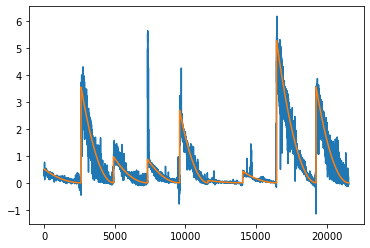

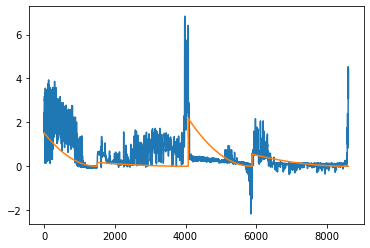

In [171]:
pplot.plot(res_source_y);
pplot.plot(yrem_norm_source);
pplot.show()

pplot.plot(res_target_y);
pplot.plot(yrem_norm_target);


In [63]:
# save_folder = get_folder_name_from_parametrization(parametrization)
# model.save_weights
# h = history_d.history
# h = pd.DataFrame(h)


NameError: name 'get_folder_name_from_parametrization' is not defined

In [65]:
insp_model_PdNy_PyNd = Model(disc_adv.input,outputs = [disc_adv.get_layer("P_d_C_y").output,disc_adv.get_layer("P_y_C_d").output])

In [66]:
max_rem = np.max([*yrem_norm_target *yrem_norm_target])

/home/charilaos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


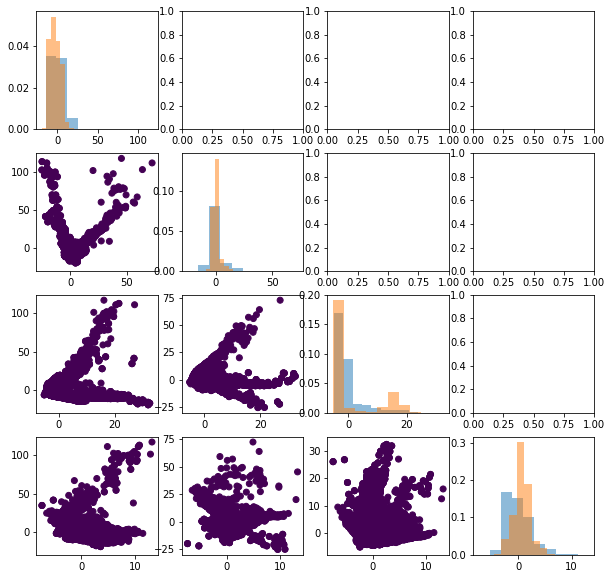

In [71]:

                
Y_PdNy , Y_PyNd = insp_model_PdNy_PyNd.predict(X_source_experiments, batch_size=100)
Y_PdNy_target , Y_PyNd_target = insp_model_PdNy_PyNd.predict(X_target_experiments, batch_size=100)

pplot.figure(figsize = (10,10))
from sklearn.decomposition import PCA
pca_pynd = PCA(n_components=4).fit(Y_PyNd) 
y_pynd = pca_pynd.transform(Y_PyNd)

pca_pdny = PCA(n_components=3).fit(Y_PdNy)
y_pdny = pca_pynd.transform(Y_PdNy)

#y2 = PCA(n_components=3).fit_transform(Y_PdNy[:,:]) 
y_pynd_target = pca_pynd.transform(Y_PyNd_target)

plot_pca_comps(y_pynd, np.ones_like(yrem_norm_source)*2)
plot_pca_comps(y_pynd_target, np.ones_like(yrem_norm_target))
#pplot.subplot(4,4,5)
#pplot.colorbar()
pplot.show();


In [72]:
pred_model = Model(disc_adv.input,outputs = disc_adv.get_layer("P_y_C_d_predictor").outputs)
y_target_hat = pred_model.predict(x_train,batch_size = 50)


In [143]:

import datetime
d = datetime.datetime.now()
closs = 0;
folder = d.strftime("{0:s}_%d-%m-%y_%T_closs{1:2.3f}".format("Dilated_DenseNet",closs))

write_folder = os.path.join(os.path.curdir,"saved_models", folder);

os.mkdir(write_folder)
model.save_weights(os.path.join(write_folder, "weights.bin"))
with open(os.path.join(write_folder, "model_spec.json"),'w') as f:
    f.write(json.dumps(model_json, indent = 4))
#!mkdir saved_moels
#model.save_weights()


In [74]:
!tree saved_models/

saved_models/
└── Dilated_DenseNet_05-03-20_18:04:51_closs0.000
    ├── checkpoint
    ├── model_spec.json
    ├── weights.bin.data-00000-of-00002
    ├── weights.bin.data-00001-of-00002
    └── weights.bin.index

1 directory, 5 files


In [ ]:
pplot.plot(history_d.history['loss'])
pplot.plot(history_d.history['val_loss'])

In [80]:
from ipywidgets import IntSlider
import scipy
from scipy import signal
#X[:,0]
import scipy
@interact(ii = IntSlider(min = 0 , max = 2000),ii2 = IntSlider(min = 0 , max = 2000), ee = IntSlider(min = 0, max = 16), nperseg = IntSlider(min = 64, max = 512))
def aa_(ii,ii2,ee,nperseg):
    x = X[eid == ee];
    print(np.unique(np.argmax(loading_oh[eid == ee],1)))
    print(len(x))
    #scipy.signal.fft(X[:,0])
    if ii2 > len(x): ii2 = len(x)-1
    if ii > len(x): ii = len(x)-1
    s1 = np.abs(signal.stft(x[ii][:,1],nperseg = nperseg)[2])
    s2 = np.abs(signal.stft(x[ii2][:,1],nperseg = nperseg)[2])
    pplot.pcolor(np.hstack([s1,s2]))
        

interactive(children=(IntSlider(value=0, description='ii', max=2000), IntSlider(value=0, description='ii2', ma…

In [145]:
all_files

['AccB_2_7.pickle',
 'AccB_1_7.pickle',
 'AccB_3_2.pickle',
 'AccB_3_1.pickle',
 'AccB_1_2.pickle',
 'AccB_1_3.pickle',
 'AccB_1_5.pickle',
 'AccB_2_3.pickle',
 'AccB_1_4.pickle',
 'AccB_2_5.pickle',
 'AccB_2_6.pickle',
 'AccB_3_3.pickle',
 'AccB_2_2.pickle',
 'AccB_2_1.pickle',
 'AccB_2_4.pickle',
 'AccB_1_1.pickle',
 'AccB_1_6.pickle']

In [150]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  "get_ipython().system('ls bearing_fatigue_dataset/')",
  'import tensorflow as tf\n#tf.enable_eager_execution()\nimport tensorflow.keras as keras\nimport numpy as np\nimport matplotlib.pyplot as pplot\nfrom tensorflow.keras import Model\nfrom tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout\n\nimport os\n\nfrom tensorflow.compat.v1 import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\nconfig = ConfigProto()\nconfig.gpu_options.allow_growth = True\nsess = InteractiveSession(config=config)\n#tf.keras.backend.set_session(sess)\n#from tensorflow.math import confusion_matrix',
  'tf.__version__',
  'from src.dilated_

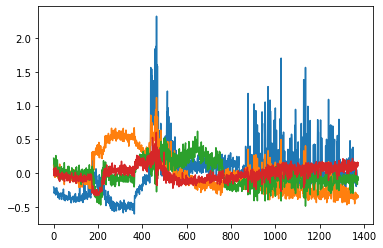

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
y = pca.fit_transform(np.vstack([np.mean(z0,1),np.mean(z1,1)]))
pplot.plot(y)

In [37]:
del z0,z1
z0 = inspect_ddout.predict(X[eid == 1],batch_size = 20)
z1 = inspect_ddout.predict(X[eid == 5], batch_size = 20)

MemoryError: Unable to allocate array with shape (1802, 2559, 400) and data type float32

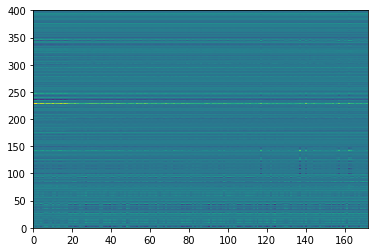

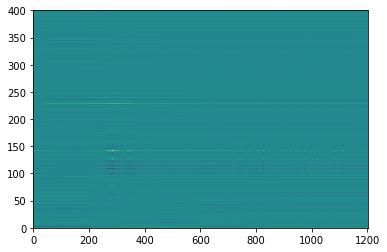

In [28]:
pplot.pcolor(np.mean(z0,1).T)
pplot.show()
pplot.pcolor(np.mean(z1,1).T)


In [23]:
inspect_ddout = Model(inputs = model.get_layer("timeseries_input").input,outputs = model.get_layer("DN_DN1_Out").output)
#inspect_ddout.predict()

In [63]:
#np.sum(y_train < 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 2559, 2)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 2559, 50)     150         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 2559, 50)     15100       DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 2559, 50)     15100       DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]             

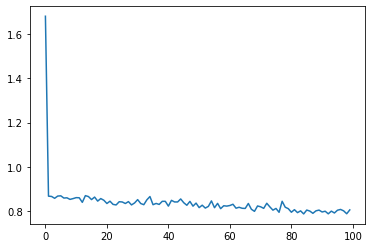

In [57]:
pplot.plot(history_d.history['val_Y_output_loss'])
#pplot.plot(history_d.history['loss'])
#pplot.savefig("asdf.png")


asdf.png
